In [131]:
#!pip install -r --user requirements.txt

In [132]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
import kerastuner
import utils

from kerastuner import HyperModel
from numpy import array
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.activations import elu, relu, swish
from math import sqrt
from tensorflow.keras import backend as K
from timeit import default_timer as timer

params = utils.Params('init_params.json')

In [133]:
def create_directory(save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

#### Load parameters

In [134]:
dataset = params.dataset
window_size = params.window_size
stride_size = params.stride_size
num_covariates = params.num_covariates
pred_days= params.pred_days

model_name= params.model_name
model_save_folder_name = params.model_save_folder_name

In [135]:
model_save_file = model_name+'_best'
model_save_folder = os.path.join(dataset, model_save_folder_name)

create_directory(model_save_folder)

n_input = window_size-pred_days
load_path = os.path.join(dataset, 'cross_validation')
load_path

'Dhaka\\cross_validation'

In [136]:
model_save_folder, model_save_file

('Dhaka\\final_models', 'lstm_ae_best')

#### Load data from saved files

In [137]:
x_input_train = None
label_train = None 

x_input_val = None
label_val = None 

x_input_test = None
label_test = None 

prediction_day_train = None
prediction_day_val = None
prediction_day_test = None

for index in range(4):

    folder_path = os.path.join(load_path,str(index))

    x_input_train = np.load(os.path.join(folder_path, dataset+'_data_train.npy'))
    x_input_val = np.load(os.path.join(folder_path, dataset+'_data_validation.npy'))
    x_input_test = np.load(os.path.join(folder_path, dataset+'_data_test.npy'))
    
    label_train = np.load(os.path.join(folder_path, dataset+'_label_train.npy'))
    label_val = np.load(os.path.join(folder_path, dataset+'_label_validation.npy'))
    label_test = np.load(os.path.join(folder_path, dataset+'_label_test.npy'))

    prediction_day_train = np.load(os.path.join(folder_path, dataset+'_prediction_day_train.npy'), allow_pickle=True)
    prediction_day_val = np.load(os.path.join(folder_path, dataset+'_prediction_day_validation.npy'), allow_pickle=True)
    prediction_day_test = np.load(os.path.join(folder_path, dataset+'_prediction_day_test.npy'), allow_pickle=True)
    
    
    print('\n\nFold', index)
    print('Train', x_input_train.shape,label_train.shape )
    print('Val',x_input_val.shape, label_val.shape)
    print('Test',x_input_test.shape, label_test.shape)



Fold 0
Train (269, 91, 17) (269, 7, 1)
Val (359, 91, 17) (359, 7, 1)
Test (359, 91, 17) (359, 7, 1)


Fold 1
Train (634, 91, 17) (634, 7, 1)
Val (359, 91, 17) (359, 7, 1)
Test (359, 91, 17) (359, 7, 1)


Fold 2
Train (999, 91, 17) (999, 7, 1)
Val (359, 91, 17) (359, 7, 1)
Test (359, 91, 17) (359, 7, 1)


Fold 3
Train (1364, 91, 17) (1364, 7, 1)
Val (359, 91, 17) (359, 7, 1)
Test (359, 91, 17) (359, 7, 1)


In [138]:
#check if there is nan
assert not np.any(np.isnan(x_input_train))# check if none is in the dataset
x_input_train.shape,label_train.shape, x_input_val.shape, label_val.shape, x_input_test.shape, label_test.shape

((1364, 91, 17),
 (1364, 7, 1),
 (359, 91, 17),
 (359, 7, 1),
 (359, 91, 17),
 (359, 7, 1))

### Model Building

In [139]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [140]:
def inverse_transform_fun(actual, predicted, test_val):
    
    for i in range(actual.shape[1]):
        if test_val:
            actual_val = actual[:, i].reshape(actual.shape[0],1)
            actual[:, i] = scaler_train.inverse_transform(actual_val).reshape(actual[:, i].shape)
            
            predicted_val = predicted[:, i].reshape(predicted.shape[0],1)
            predicted[:, i]  = scaler_val.inverse_transform(predicted_val).reshape(predicted[:, i].shape)
        else:
            actual_val = actual[:, i].reshape(actual.shape[0],1)
            actual[:, i] = scaler_val.inverse_transform(actual_val).reshape(actual[:, i].shape)
            
            predicted_val = predicted[:, i].reshape(predicted.shape[0],1)
            predicted[:, i]  = scaler_test.inverse_transform(predicted_val).reshape(predicted[:, i].shape)
    return actual, predicted

In [141]:
# evaluate a single model ## Unused
def evaluate_model_train(test_x, test_y, n_input, train_model = False, model = None, test_val = False,\
                   normalize = False, plot = False): 
    train_x = test_x[:1,:,:]
    # history is a list of weekly data
    history = [x for x in train_x]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test_y)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        #print(yhat_sequence)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        if i+1<len(test_y):
            history.append(test_x[i+1, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    #print('predictions', predictions)
    plot_prediction(test_x, test_y, predictions, model = 'lstm_test', plot = plot)
    score, scores = evaluate_forecasts(test_y[:, :, 0], predictions, test_val = test_val, normalize = normalize)
    if train_model:
        return model,hist,score, scores
    else:
        return score,scores

In [142]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    #print(data.shape)
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    #print('input_x.shape', input_x.shape)
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    #model.reset_states()
    # we only want the vector forecast
    yhat = yhat[0]
    #print(yhat.shape)
    return yhat

In [143]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted, test_val = False, normalize = False):
    scores = list()
    
    if normalize:
        #print('normalize')
        actual, predicted = inverse_transform_fun(actual, predicted, test_val)
    
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [144]:
def plot_train_history(history):
    # Plot history: MAE
    plt.clf()
    plt.plot(history.history['loss'], label='MSE (training data)')
    plt.plot(history.history['val_loss'], label='MSE (validation data)')
    plt.ylabel('RMSE value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()
    plt.savefig('loss.png')

In [145]:
def plot_prediction(x, y_true, y_pred, prediction_dates, model = model_name, train = False, plot = False):
    """Plots the predictions.
    
    Arguments
    ---------
    x: Input sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_true: True output sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_pred: Predicted output sequence (input_sequence_length,
        dimension_of_signal)
    """
    total_predctions = x.shape[0]
    rmse_list = []
    mae_list = []

    result = pd.DataFrame(columns=('date', 'station', 'true', 'pred'))
    save_path = os.path.join(dataset, 'visualizations', model)
    create_directory(save_path)
    
    for j in range(total_predctions):
        #prediction_day_test[j][0]
        past = x[j, :,0] 
        true = y_true[j, :]
        pred = y_pred[j, :]
        
        new_row = {'date':prediction_dates[j][0], 'station':dataset, 'true':true.flatten(), 'pred':pred.flatten()}
        result = result.append(new_row, ignore_index=True)
        
        rmse = sqrt(mean_squared_error(pred, true))
        mae = mean_absolute_error(pred, true)
        rmse_list.append(rmse)   
        mae_list.append(mae)
        label1 = "Seen (past) values" if j==0 else "_nolegend_"
        label2 = "True future values" if j==0 else "_nolegend_"
        label3 = "Predictions" if j==0 else "_nolegend_"
        if plot and rmse<10:
            #print(past.shape)
            plt.figure(figsize=(15, 3))
            plt.clf()
            plt.plot(range(len(past)), past, "x--y", label=label1)
            plt.plot(range(len(past),len(true)+len(past)), true, label=label2)
            plt.plot(range(len(past), len(pred)+len(past)), pred, "x--y",label=label3, color = 'red')
            plt.legend(loc='best')
            plt.title("{in1}, Predictions v.s. true values, RMSE:{in2}".format(in1=prediction_dates[j][0], in2=rmse))
            plt.savefig("{in1}/visualizations/{in2}/sample_{in3}.png".format(in1 = dataset, in2=model, in3=j))
            plt.show()
    result.to_csv(os.path.join(dataset, 'visualizations', model, 'result.csv'))
    print(sum(rmse_list), len(rmse_list))
    print( 'Average RMSE per sample: ', sum(rmse_list) / float(len(rmse_list)) )
    print( 'Average MAE per sample: ', sum(mae_list) / float(len(mae_list)) )

In [146]:
# evaluate a single model
def evaluate_model(train_x, train_y, test_x, test_y, prediction_dates, n_input, train_model = False, model = None, test_val = False,\
                   normalize = False, plot = False, save_path = model_name): 
    # fit model
    if train_model:
        model, hist = build_model(train_x, train_y, n_input)
        plot_train_history(hist)
    # history is a list of weekly data
    history = [x for x in train_x]
    #print('history',len(history), history[0].shape)
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test_y)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        #print(yhat_sequence)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test_x[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    #print('predictions', predictions)
    plot_prediction(test_x, test_y, predictions, prediction_dates, model = save_path, plot = plot)
    score, scores = evaluate_forecasts(test_y[:, :, 0], predictions, test_val = test_val, normalize = normalize)
    if train_model:
        return model,hist,score, scores
    else:
        return score,scores

In [147]:
# train the model
def build_model(train_x, train_y, n_input, verbose = 0):
    # define parameters
    epochs, batch_size = 200, 64
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

    # these are just made up hyperparameters, change them as you wish
    hidden_size = 50
    
    model = tf.keras.Sequential([

        tf.keras.layers.LSTM(hidden_size, input_shape = train_x.shape[-2:]),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, input_shape = train_x.shape[-2:])),
        tf.keras.layers.Dropout(rate=0.2),
        
        tf.keras.layers.RepeatVector(n_outputs),

        tf.keras.layers.LSTM(hidden_size, return_sequences = True), 
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, return_sequences = True)),
        tf.keras.layers.Dense(120, activation = swish),
        tf.keras.layers.Dropout(rate=0.4),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation = relu))

    ])

    opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6)#lr=0.001, decay=1e-6)
    #opt = tf.keras.optimizers.Adam()
    model.compile(optimizer=opt, loss = 'mean_squared_error', metrics=root_mean_squared_error)

    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    
    history = model.fit(train_x, train_y, epochs=epochs,  validation_data=(x_input_val,label_val),\
                                   batch_size=batch_size, verbose=verbose, callbacks=[TerminateOnNaN(),es,mc])
    #model.reset_states()
    return model,history

In [148]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [149]:
# fit model
# n_input = window_size-pred_days # timestamps
# model,hist = build_model(x_input_train, label_train, n_input, verbose = 1)
# plot_train_history(hist)

In [150]:
# model = tf.keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error':root_mean_squared_error})
# model.summary()

## Optimization Code

In [151]:
class Recurrent_Regression_HyperModel(HyperModel):
    
    def __init__(self, input_shape, n_outputs, selected_model):
        self.train_x = input_shape
        self.n_outputs = n_outputs
        self.model_name = selected_model
        
    def build(self, hp):
        
        LATENT_DIM = hp.Int('latent_dim', min_value=25, max_value=100, step=25, default=25)
        model = None
        
        if self.model_name.lower() =='rnn_ae':
            
            model = tf.keras.Sequential([


                tf.keras.layers.SimpleRNN(LATENT_DIM, input_shape = self.train_x),

                tf.keras.layers.Dropout(hp.Float(
                                        'dropout1',
                                        min_value=0.0,
                                        max_value=0.5,
                                        default=0.2,
                                        step=0.1)),

                tf.keras.layers.RepeatVector(self.n_outputs),
                tf.keras.layers.SimpleRNN(LATENT_DIM, return_sequences = True),
 
                tf.keras.layers.Dense(units=hp.Int('decoder_hidden_units', 10, 120, 10, default=round(LATENT_DIM/2)),
                                      activation=hp.Choice(
                                        'dense_activation1',
                                        values=['relu', 'elu', 'swish'],
                                        default='elu')),

                tf.keras.layers.Dropout(hp.Float(
                                        'dropout2',
                                        min_value=0.0,
                                        max_value=0.5,
                                        default=0.2,
                                        step=0.1)),

                tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation=hp.Choice(
                                        'output_activation',
                                        values=['relu', 'elu', 'swish'],
                                        default='elu')))

            ])
            
        elif self.model_name.lower() =='bi_lstm_ae':
            
            model = tf.keras.Sequential([

                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LATENT_DIM, input_shape = self.train_x)),

                tf.keras.layers.Dropout(hp.Float(
                                        'dropout1',
                                        min_value=0.0,
                                        max_value=0.5,
                                        default=0.2,
                                        step=0.1)),

                tf.keras.layers.RepeatVector(self.n_outputs),

                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LATENT_DIM, return_sequences = True)),

                tf.keras.layers.Dense(units=hp.Int('decoder_hidden_units', 10, 120, 10, default=round(LATENT_DIM/2)),
                                      activation=hp.Choice(
                                        'dense_activation1',
                                        values=['relu', 'elu', 'swish'],
                                        default='elu')),

                tf.keras.layers.Dropout(hp.Float(
                                        'dropout2',
                                        min_value=0.0,
                                        max_value=0.5,
                                        default=0.2,
                                        step=0.1)),

                tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation=hp.Choice(
                                        'output_activation',
                                        values=['relu', 'elu', 'swish'],
                                        default='elu')))

            ])
        elif self.model_name.lower()=='lstm_ae':
            
            model = tf.keras.Sequential([


                tf.keras.layers.LSTM(LATENT_DIM, input_shape = self.train_x),
                
                tf.keras.layers.Dropout(hp.Float(
                                        'dropout1',
                                        min_value=0.0,
                                        max_value=0.5,
                                        default=0.2,
                                        step=0.1)),

                tf.keras.layers.RepeatVector(self.n_outputs),
                tf.keras.layers.LSTM(LATENT_DIM, return_sequences = True),
                
                tf.keras.layers.Dense(units=hp.Int('decoder_hidden_units', 10, 120, 10, default=round(LATENT_DIM/2)),
                                      activation=hp.Choice(
                                        'dense_activation1',
                                        values=['relu', 'elu', 'swish'],
                                        default='elu')),

                tf.keras.layers.Dropout(hp.Float(
                                        'dropout2',
                                        min_value=0.0,
                                        max_value=0.5,
                                        default=0.2,
                                        step=0.1)),

                tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation=hp.Choice(
                                        'output_activation',
                                        values=['relu', 'elu', 'swish'],
                                        default='elu')))

            ])
            
        hp_learning_rate = hp.Choice('learning_rate', values = [1e-3, 1e-4, 1e-5])     
        model.compile(
            optimizer=tf.keras.optimizers.Adam(hp_learning_rate, decay=1e-6),
            loss='mean_squared_error',metrics=root_mean_squared_error
        )

        return model

In [152]:
input_shape = x_input_train.shape[-2:]
hypermodel = Recurrent_Regression_HyperModel(input_shape,7, model_name)

In [153]:
class MyTuner(kerastuner.tuners.BayesianOptimization):
    
    def run_trial(self, trial, *args, **kwargs):
        # You can add additional HyperParameters for preprocessing and custom training loops
        # via overriding `run_trial`
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 16, 64, step=16)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

# Uses same arguments as the BayesianOptimization Tuner.
tuner_bo = MyTuner(
            hypermodel,
            objective = kerastuner.Objective('val_root_mean_squared_error', direction="min"),
            max_trials= params.max_number_of_trials,
            seed=42,
            executions_per_trial=3,
            directory=os.path.normpath(os.path.join(dataset, 'HPO')),
            overwrite = True,
            project_name = model_name
        )

In [154]:
tuner_bo.search_space_summary()

#### Run Optimization with Adam

In [155]:
model_save_folder, model_save_file, model_name

('Dhaka\\final_models', 'lstm_ae_best', 'lstm_ae')

In [156]:
# simple early stopping
start = timer()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
mc = ModelCheckpoint(os.path.join(model_save_folder, model_save_file+'_last.h5'), monitor='val_root_mean_squared_error', mode='min', verbose=1, save_best_only=True)

tuner_bo.search(x_input_train, label_train, epochs=300, validation_data=(x_input_val,label_val), verbose=0,\
               callbacks=[TerminateOnNaN(), es,mc])
best_model = tuner_bo.get_best_models(num_models=1)[0]
best_model.evaluate(x_input_test, label_test)
best_model.save(os.path.join(model_save_folder, model_save_file+'.h5'), overwrite=True) 
best_model.summary()
end = timer()


Epoch 00001: val_root_mean_squared_error improved from inf to 84.32835, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 84.32835 to 84.04443, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 84.04443 to 83.72476, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 83.72476 to 83.35576, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 83.35576 to 82.92580, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 82.92580 to 82.42674, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 82.42674 to 81.84474, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error improved from 81.84474 to

Epoch 00062: val_root_mean_squared_error improved from 52.86197 to 52.67059, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00063: val_root_mean_squared_error improved from 52.67059 to 52.48648, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00064: val_root_mean_squared_error improved from 52.48648 to 52.31170, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00065: val_root_mean_squared_error improved from 52.31170 to 52.14079, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00066: val_root_mean_squared_error improved from 52.14079 to 51.98061, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00067: val_root_mean_squared_error improved from 51.98061 to 51.82232, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00068: val_root_mean_squared_error improved from 51.82232 to 51.67485, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00069: val_root_mean_squared_error improved from 51.6748

Epoch 00133: val_root_mean_squared_error improved from 39.60675 to 39.28318, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00134: val_root_mean_squared_error improved from 39.28318 to 38.98210, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00135: val_root_mean_squared_error improved from 38.98210 to 38.75709, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00136: val_root_mean_squared_error improved from 38.75709 to 38.48136, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00137: val_root_mean_squared_error improved from 38.48136 to 38.25343, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00138: val_root_mean_squared_error improved from 38.25343 to 38.02378, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00139: val_root_mean_squared_error improved from 38.02378 to 37.72195, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00140: val_root_mean_squared_error improved from 37.7219

Epoch 00194: val_root_mean_squared_error improved from 28.89304 to 28.76144, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00195: val_root_mean_squared_error improved from 28.76144 to 28.64707, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00196: val_root_mean_squared_error improved from 28.64707 to 28.57169, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00197: val_root_mean_squared_error improved from 28.57169 to 28.55619, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00198: val_root_mean_squared_error improved from 28.55619 to 28.39824, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00199: val_root_mean_squared_error improved from 28.39824 to 28.29292, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00200: val_root_mean_squared_error improved from 28.29292 to 28.24436, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00201: val_root_mean_squared_error improved from 28.2443

Epoch 00265: val_root_mean_squared_error improved from 22.71946 to 22.69262, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00266: val_root_mean_squared_error improved from 22.69262 to 22.67444, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00267: val_root_mean_squared_error did not improve from 22.67444

Epoch 00268: val_root_mean_squared_error did not improve from 22.67444

Epoch 00269: val_root_mean_squared_error improved from 22.67444 to 22.50119, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00270: val_root_mean_squared_error did not improve from 22.50119

Epoch 00271: val_root_mean_squared_error improved from 22.50119 to 22.38624, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00272: val_root_mean_squared_error did not improve from 22.38624

Epoch 00273: val_root_mean_squared_error did not improve from 22.38624

Epoch 00274: val_root_mean_squared_error did not improve from 22.38624

Epoch 00275: val_root_mean_squar

Epoch 00036: val_root_mean_squared_error improved from 62.20756 to 61.70820, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00037: val_root_mean_squared_error improved from 61.70820 to 61.23286, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00038: val_root_mean_squared_error improved from 61.23286 to 60.76513, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00039: val_root_mean_squared_error improved from 60.76513 to 60.30610, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00040: val_root_mean_squared_error improved from 60.30610 to 59.86554, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00041: val_root_mean_squared_error improved from 59.86554 to 59.43270, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00042: val_root_mean_squared_error improved from 59.43270 to 59.01236, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00043: val_root_mean_squared_error improved from 59.0123

Epoch 00097: val_root_mean_squared_error improved from 49.64144 to 49.62142, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00098: val_root_mean_squared_error improved from 49.62142 to 49.60467, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00099: val_root_mean_squared_error improved from 49.60467 to 49.59075, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00100: val_root_mean_squared_error improved from 49.59075 to 49.57991, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00101: val_root_mean_squared_error improved from 49.57991 to 49.57199, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00102: val_root_mean_squared_error improved from 49.57199 to 49.56650, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00103: val_root_mean_squared_error improved from 49.56650 to 49.56281, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00104: val_root_mean_squared_error improved from 49.5628

Epoch 00164: val_root_mean_squared_error improved from 32.71801 to 32.48185, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00165: val_root_mean_squared_error improved from 32.48185 to 32.37469, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00166: val_root_mean_squared_error improved from 32.37469 to 32.24794, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00167: val_root_mean_squared_error improved from 32.24794 to 32.06950, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00168: val_root_mean_squared_error improved from 32.06950 to 31.90547, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00169: val_root_mean_squared_error did not improve from 31.90547

Epoch 00170: val_root_mean_squared_error improved from 31.90547 to 31.75127, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00171: val_root_mean_squared_error improved from 31.75127 to 31.48884, saving model to Dhaka\final_models\lstm_ae_best


Epoch 00227: val_root_mean_squared_error did not improve from 25.13950

Epoch 00228: val_root_mean_squared_error improved from 25.13950 to 24.78062, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00229: val_root_mean_squared_error improved from 24.78062 to 24.76273, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00230: val_root_mean_squared_error improved from 24.76273 to 24.54364, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00231: val_root_mean_squared_error improved from 24.54364 to 24.51891, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00232: val_root_mean_squared_error improved from 24.51891 to 24.37191, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00233: val_root_mean_squared_error improved from 24.37191 to 24.35123, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00234: val_root_mean_squared_error improved from 24.35123 to 24.31317, saving model to Dhaka\final_models\lstm_ae_bes

Epoch 00003: val_root_mean_squared_error improved from 84.33232 to 84.00139, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 84.00139 to 83.66505, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 83.66505 to 83.29807, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 83.29807 to 82.89038, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 82.89038 to 82.44132, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error improved from 82.44132 to 81.94395, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00009: val_root_mean_squared_error improved from 81.94395 to 81.39783, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00010: val_root_mean_squared_error improved from 81.3978

Epoch 00064: val_root_mean_squared_error improved from 53.32872 to 53.11306, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00065: val_root_mean_squared_error improved from 53.11306 to 52.90170, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00066: val_root_mean_squared_error improved from 52.90170 to 52.69579, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00067: val_root_mean_squared_error improved from 52.69579 to 52.50723, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00068: val_root_mean_squared_error improved from 52.50723 to 52.32334, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00069: val_root_mean_squared_error improved from 52.32334 to 52.14224, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00070: val_root_mean_squared_error improved from 52.14224 to 51.97296, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00071: val_root_mean_squared_error improved from 51.9729

Epoch 00129: val_root_mean_squared_error improved from 43.51044 to 43.03381, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00130: val_root_mean_squared_error improved from 43.03381 to 42.07570, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00131: val_root_mean_squared_error improved from 42.07570 to 41.24906, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00132: val_root_mean_squared_error improved from 41.24906 to 40.67675, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00133: val_root_mean_squared_error improved from 40.67675 to 40.12099, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00134: val_root_mean_squared_error improved from 40.12099 to 39.51610, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00135: val_root_mean_squared_error improved from 39.51610 to 39.07704, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00136: val_root_mean_squared_error improved from 39.0770

Epoch 00190: val_root_mean_squared_error improved from 29.09749 to 28.96884, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00191: val_root_mean_squared_error improved from 28.96884 to 28.82994, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00192: val_root_mean_squared_error improved from 28.82994 to 28.69728, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00193: val_root_mean_squared_error improved from 28.69728 to 28.57334, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00194: val_root_mean_squared_error improved from 28.57334 to 28.41649, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00195: val_root_mean_squared_error improved from 28.41649 to 28.28305, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00196: val_root_mean_squared_error improved from 28.28305 to 28.09798, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00197: val_root_mean_squared_error improved from 28.0979

Epoch 00252: val_root_mean_squared_error improved from 22.84018 to 22.72956, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00253: val_root_mean_squared_error improved from 22.72956 to 22.64966, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00254: val_root_mean_squared_error did not improve from 22.64966

Epoch 00255: val_root_mean_squared_error improved from 22.64966 to 22.58525, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00256: val_root_mean_squared_error improved from 22.58525 to 22.19591, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00257: val_root_mean_squared_error did not improve from 22.19591

Epoch 00258: val_root_mean_squared_error improved from 22.19591 to 22.15790, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00259: val_root_mean_squared_error improved from 22.15790 to 22.01486, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00260: val_root_mean_squared_error improved fr


Epoch 00001: val_root_mean_squared_error improved from inf to 86.45117, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 86.45117 to 82.21621, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 82.21621 to 75.46150, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 75.46150 to 67.77168, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 67.77168 to 60.56771, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 60.56771 to 55.95262, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 55.95262 to 53.50975, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error improved from 53.50975 to

Epoch 00086: val_root_mean_squared_error did not improve from 19.65188

Epoch 00087: val_root_mean_squared_error did not improve from 19.65188

Epoch 00088: val_root_mean_squared_error did not improve from 19.65188

Epoch 00089: val_root_mean_squared_error did not improve from 19.65188

Epoch 00090: val_root_mean_squared_error did not improve from 19.65188

Epoch 00091: val_root_mean_squared_error did not improve from 19.65188

Epoch 00092: val_root_mean_squared_error did not improve from 19.65188

Epoch 00093: val_root_mean_squared_error did not improve from 19.65188

Epoch 00094: val_root_mean_squared_error did not improve from 19.65188

Epoch 00095: val_root_mean_squared_error did not improve from 19.65188

Epoch 00096: val_root_mean_squared_error did not improve from 19.65188
Epoch 00096: early stopping

Epoch 00001: val_root_mean_squared_error improved from inf to 85.88816, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved f

Epoch 00077: val_root_mean_squared_error did not improve from 19.73546

Epoch 00078: val_root_mean_squared_error did not improve from 19.73546

Epoch 00079: val_root_mean_squared_error did not improve from 19.73546

Epoch 00080: val_root_mean_squared_error did not improve from 19.73546

Epoch 00081: val_root_mean_squared_error did not improve from 19.73546

Epoch 00082: val_root_mean_squared_error did not improve from 19.73546

Epoch 00083: val_root_mean_squared_error did not improve from 19.73546

Epoch 00084: val_root_mean_squared_error did not improve from 19.73546

Epoch 00085: val_root_mean_squared_error did not improve from 19.73546

Epoch 00086: val_root_mean_squared_error did not improve from 19.73546

Epoch 00087: val_root_mean_squared_error did not improve from 19.73546
Epoch 00087: early stopping

Epoch 00001: val_root_mean_squared_error improved from inf to 85.72575, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved f

Epoch 00074: val_root_mean_squared_error did not improve from 19.28473

Epoch 00075: val_root_mean_squared_error did not improve from 19.28473

Epoch 00076: val_root_mean_squared_error did not improve from 19.28473

Epoch 00077: val_root_mean_squared_error did not improve from 19.28473

Epoch 00078: val_root_mean_squared_error did not improve from 19.28473

Epoch 00079: val_root_mean_squared_error did not improve from 19.28473

Epoch 00080: val_root_mean_squared_error did not improve from 19.28473

Epoch 00081: val_root_mean_squared_error did not improve from 19.28473

Epoch 00082: val_root_mean_squared_error did not improve from 19.28473

Epoch 00083: val_root_mean_squared_error did not improve from 19.28473

Epoch 00084: val_root_mean_squared_error did not improve from 19.28473

Epoch 00085: val_root_mean_squared_error did not improve from 19.28473

Epoch 00086: val_root_mean_squared_error did not improve from 19.28473

Epoch 00087: val_root_mean_squared_error did not improve from 19


Epoch 00001: val_root_mean_squared_error improved from inf to 82.00034, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 82.00034 to 66.62912, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 66.62912 to 54.65964, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 54.65964 to 52.11147, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error did not improve from 52.11147

Epoch 00006: val_root_mean_squared_error improved from 52.11147 to 39.52877, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 39.52877 to 33.15003, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error improved from 33.15003 to 27.69386, saving model to Dhaka\final_models\lstm_ae_best_las

Epoch 00019: val_root_mean_squared_error improved from 21.52106 to 21.28471, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00020: val_root_mean_squared_error improved from 21.28471 to 21.01043, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00021: val_root_mean_squared_error did not improve from 21.01043

Epoch 00022: val_root_mean_squared_error did not improve from 21.01043

Epoch 00023: val_root_mean_squared_error improved from 21.01043 to 20.81515, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00024: val_root_mean_squared_error improved from 20.81515 to 20.54418, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00025: val_root_mean_squared_error did not improve from 20.54418

Epoch 00026: val_root_mean_squared_error improved from 20.54418 to 20.32332, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00027: val_root_mean_squared_error did not improve from 20.32332

Epoch 00028: val_root_mean_squared_error d

Epoch 00012: val_root_mean_squared_error improved from 23.78591 to 22.88904, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00013: val_root_mean_squared_error did not improve from 22.88904

Epoch 00014: val_root_mean_squared_error improved from 22.88904 to 22.07966, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error did not improve from 22.07966

Epoch 00016: val_root_mean_squared_error did not improve from 22.07966

Epoch 00017: val_root_mean_squared_error improved from 22.07966 to 21.45216, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error improved from 21.45216 to 21.41559, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00019: val_root_mean_squared_error improved from 21.41559 to 21.24672, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00020: val_root_mean_squared_error improved from 21.24672 to 21.13292, saving model to Dhaka\final_models\ls


Epoch 00001: val_root_mean_squared_error improved from inf to 87.29691, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 87.29691 to 84.94382, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 84.94382 to 81.07046, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 81.07046 to 76.63412, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 76.63412 to 72.46526, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 72.46526 to 68.49378, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 68.49378 to 64.83924, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error improved from 64.83924 to

Epoch 00080: val_root_mean_squared_error did not improve from 20.15879

Epoch 00081: val_root_mean_squared_error did not improve from 20.15879

Epoch 00082: val_root_mean_squared_error did not improve from 20.15879

Epoch 00083: val_root_mean_squared_error did not improve from 20.15879

Epoch 00084: val_root_mean_squared_error did not improve from 20.15879

Epoch 00085: val_root_mean_squared_error did not improve from 20.15879

Epoch 00086: val_root_mean_squared_error did not improve from 20.15879

Epoch 00087: val_root_mean_squared_error did not improve from 20.15879

Epoch 00088: val_root_mean_squared_error did not improve from 20.15879

Epoch 00089: val_root_mean_squared_error did not improve from 20.15879

Epoch 00090: val_root_mean_squared_error did not improve from 20.15879
Epoch 00090: early stopping

Epoch 00001: val_root_mean_squared_error improved from inf to 87.59237, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved f

Epoch 00064: val_root_mean_squared_error did not improve from 21.41315

Epoch 00065: val_root_mean_squared_error did not improve from 21.41315

Epoch 00066: val_root_mean_squared_error did not improve from 21.41315

Epoch 00067: val_root_mean_squared_error improved from 21.41315 to 21.37772, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00068: val_root_mean_squared_error improved from 21.37772 to 21.28233, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00069: val_root_mean_squared_error did not improve from 21.28233

Epoch 00070: val_root_mean_squared_error did not improve from 21.28233

Epoch 00071: val_root_mean_squared_error did not improve from 21.28233

Epoch 00072: val_root_mean_squared_error did not improve from 21.28233

Epoch 00073: val_root_mean_squared_error did not improve from 21.28233

Epoch 00074: val_root_mean_squared_error did not improve from 21.28233

Epoch 00075: val_root_mean_squared_error did not improve from 21.28233

Epoch 00076:

Epoch 00010: val_root_mean_squared_error improved from 55.81269 to 54.33511, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00011: val_root_mean_squared_error improved from 54.33511 to 53.28374, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00012: val_root_mean_squared_error improved from 53.28374 to 52.57124, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00013: val_root_mean_squared_error improved from 52.57124 to 52.16106, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00014: val_root_mean_squared_error improved from 52.16106 to 52.01046, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error did not improve from 52.01046

Epoch 00016: val_root_mean_squared_error did not improve from 52.01046

Epoch 00017: val_root_mean_squared_error did not improve from 52.01046

Epoch 00018: val_root_mean_squared_error did not improve from 52.01046

Epoch 00019: val_root_mean_squared_error d

Epoch 00102: val_root_mean_squared_error did not improve from 20.46803

Epoch 00103: val_root_mean_squared_error did not improve from 20.46803

Epoch 00104: val_root_mean_squared_error did not improve from 20.46803

Epoch 00105: val_root_mean_squared_error did not improve from 20.46803

Epoch 00106: val_root_mean_squared_error did not improve from 20.46803

Epoch 00107: val_root_mean_squared_error did not improve from 20.46803

Epoch 00108: val_root_mean_squared_error did not improve from 20.46803
Epoch 00108: early stopping



Epoch 00001: val_root_mean_squared_error improved from inf to 86.95695, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 86.95695 to 84.51780, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 84.51780 to 80.88710, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 80.88710 to 77.00696, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 77.00696 to 73.11697, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 73.11697 to 69.35905, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 69.35905 to 65.87679, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error improved from 65.87679 to

Epoch 00071: val_root_mean_squared_error did not improve from 21.23735

Epoch 00072: val_root_mean_squared_error did not improve from 21.23735

Epoch 00073: val_root_mean_squared_error improved from 21.23735 to 21.14230, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00074: val_root_mean_squared_error did not improve from 21.14230

Epoch 00075: val_root_mean_squared_error did not improve from 21.14230

Epoch 00076: val_root_mean_squared_error did not improve from 21.14230

Epoch 00077: val_root_mean_squared_error improved from 21.14230 to 21.06732, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00078: val_root_mean_squared_error did not improve from 21.06732

Epoch 00079: val_root_mean_squared_error did not improve from 21.06732

Epoch 00080: val_root_mean_squared_error did not improve from 21.06732

Epoch 00081: val_root_mean_squared_error did not improve from 21.06732

Epoch 00082: val_root_mean_squared_error did not improve from 21.06732

Epoch 00083:

Epoch 00004: val_root_mean_squared_error improved from 84.03600 to 81.82120, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 81.82120 to 79.69404, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 79.69404 to 77.63792, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 77.63792 to 75.55796, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error improved from 75.55796 to 73.49764, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00009: val_root_mean_squared_error improved from 73.49764 to 71.44287, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00010: val_root_mean_squared_error improved from 71.44287 to 69.41418, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00011: val_root_mean_squared_error improved from 69.4141

Epoch 00073: val_root_mean_squared_error did not improve from 28.61401

Epoch 00074: val_root_mean_squared_error did not improve from 28.61401

Epoch 00075: val_root_mean_squared_error did not improve from 28.61401

Epoch 00076: val_root_mean_squared_error did not improve from 28.61401

Epoch 00077: val_root_mean_squared_error improved from 28.61401 to 27.64241, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00078: val_root_mean_squared_error did not improve from 27.64241

Epoch 00079: val_root_mean_squared_error did not improve from 27.64241

Epoch 00080: val_root_mean_squared_error did not improve from 27.64241

Epoch 00081: val_root_mean_squared_error did not improve from 27.64241

Epoch 00082: val_root_mean_squared_error improved from 27.64241 to 27.63025, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00083: val_root_mean_squared_error did not improve from 27.63025

Epoch 00084: val_root_mean_squared_error did not improve from 27.63025

Epoch 00085:

Epoch 00021: val_root_mean_squared_error improved from 52.04619 to 51.98943, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00022: val_root_mean_squared_error improved from 51.98943 to 51.94502, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00023: val_root_mean_squared_error improved from 51.94502 to 51.86736, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00024: val_root_mean_squared_error improved from 51.86736 to 51.56332, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00025: val_root_mean_squared_error improved from 51.56332 to 47.63202, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00026: val_root_mean_squared_error improved from 47.63202 to 43.24402, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00027: val_root_mean_squared_error improved from 43.24402 to 40.95263, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00028: val_root_mean_squared_error improved from 40.9526

Epoch 00100: val_root_mean_squared_error did not improve from 21.28398

Epoch 00101: val_root_mean_squared_error did not improve from 21.28398

Epoch 00102: val_root_mean_squared_error did not improve from 21.28398

Epoch 00103: val_root_mean_squared_error did not improve from 21.28398

Epoch 00104: val_root_mean_squared_error did not improve from 21.28398

Epoch 00105: val_root_mean_squared_error did not improve from 21.28398

Epoch 00106: val_root_mean_squared_error did not improve from 21.28398

Epoch 00107: val_root_mean_squared_error did not improve from 21.28398

Epoch 00108: val_root_mean_squared_error did not improve from 21.28398

Epoch 00109: val_root_mean_squared_error did not improve from 21.28398

Epoch 00110: val_root_mean_squared_error did not improve from 21.28398

Epoch 00111: val_root_mean_squared_error did not improve from 21.28398

Epoch 00112: val_root_mean_squared_error did not improve from 21.28398

Epoch 00113: val_root_mean_squared_error did not improve from 21

Epoch 00210: val_root_mean_squared_error did not improve from 20.65664

Epoch 00211: val_root_mean_squared_error did not improve from 20.65664

Epoch 00212: val_root_mean_squared_error did not improve from 20.65664

Epoch 00213: val_root_mean_squared_error did not improve from 20.65664

Epoch 00214: val_root_mean_squared_error did not improve from 20.65664

Epoch 00215: val_root_mean_squared_error did not improve from 20.65664

Epoch 00216: val_root_mean_squared_error did not improve from 20.65664

Epoch 00217: val_root_mean_squared_error did not improve from 20.65664

Epoch 00218: val_root_mean_squared_error did not improve from 20.65664

Epoch 00219: val_root_mean_squared_error did not improve from 20.65664

Epoch 00220: val_root_mean_squared_error did not improve from 20.65664

Epoch 00221: val_root_mean_squared_error did not improve from 20.65664

Epoch 00222: val_root_mean_squared_error did not improve from 20.65664
Epoch 00222: early stopping



Epoch 00001: val_root_mean_squared_error improved from inf to 87.21082, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 87.21082 to 83.57827, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 83.57827 to 75.83321, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 75.83321 to 65.20943, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 65.20943 to 57.27573, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 57.27573 to 53.56944, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 53.56944 to 52.15947, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error did not improve from 52.1

Epoch 00089: val_root_mean_squared_error did not improve from 19.65934

Epoch 00090: val_root_mean_squared_error did not improve from 19.65934

Epoch 00091: val_root_mean_squared_error improved from 19.65934 to 19.63569, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00092: val_root_mean_squared_error did not improve from 19.63569

Epoch 00093: val_root_mean_squared_error did not improve from 19.63569

Epoch 00094: val_root_mean_squared_error did not improve from 19.63569

Epoch 00095: val_root_mean_squared_error did not improve from 19.63569

Epoch 00096: val_root_mean_squared_error did not improve from 19.63569

Epoch 00097: val_root_mean_squared_error did not improve from 19.63569

Epoch 00098: val_root_mean_squared_error did not improve from 19.63569

Epoch 00099: val_root_mean_squared_error did not improve from 19.63569

Epoch 00100: val_root_mean_squared_error did not improve from 19.63569

Epoch 00101: val_root_mean_squared_error did not improve from 19.63569

Ep

Epoch 00059: val_root_mean_squared_error did not improve from 20.35062

Epoch 00060: val_root_mean_squared_error did not improve from 20.35062

Epoch 00061: val_root_mean_squared_error did not improve from 20.35062

Epoch 00062: val_root_mean_squared_error did not improve from 20.35062

Epoch 00063: val_root_mean_squared_error did not improve from 20.35062

Epoch 00064: val_root_mean_squared_error did not improve from 20.35062

Epoch 00065: val_root_mean_squared_error did not improve from 20.35062

Epoch 00066: val_root_mean_squared_error did not improve from 20.35062

Epoch 00067: val_root_mean_squared_error did not improve from 20.35062

Epoch 00068: val_root_mean_squared_error did not improve from 20.35062

Epoch 00069: val_root_mean_squared_error did not improve from 20.35062

Epoch 00070: val_root_mean_squared_error did not improve from 20.35062

Epoch 00071: val_root_mean_squared_error did not improve from 20.35062

Epoch 00072: val_root_mean_squared_error did not improve from 20

Epoch 00065: val_root_mean_squared_error did not improve from 20.38293

Epoch 00066: val_root_mean_squared_error did not improve from 20.38293

Epoch 00067: val_root_mean_squared_error did not improve from 20.38293

Epoch 00068: val_root_mean_squared_error did not improve from 20.38293

Epoch 00069: val_root_mean_squared_error did not improve from 20.38293

Epoch 00070: val_root_mean_squared_error did not improve from 20.38293

Epoch 00071: val_root_mean_squared_error did not improve from 20.38293

Epoch 00072: val_root_mean_squared_error did not improve from 20.38293

Epoch 00073: val_root_mean_squared_error did not improve from 20.38293

Epoch 00074: val_root_mean_squared_error did not improve from 20.38293

Epoch 00075: val_root_mean_squared_error did not improve from 20.38293

Epoch 00076: val_root_mean_squared_error did not improve from 20.38293

Epoch 00077: val_root_mean_squared_error did not improve from 20.38293

Epoch 00078: val_root_mean_squared_error did not improve from 20


Epoch 00001: val_root_mean_squared_error improved from inf to 87.05474, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 87.05474 to 83.40083, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 83.40083 to 76.41013, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 76.41013 to 67.56946, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 67.56946 to 59.51985, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 59.51985 to 54.90005, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 54.90005 to 52.70771, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error improved from 52.70771 to

Epoch 00009: val_root_mean_squared_error improved from 52.33714 to 52.04741, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00010: val_root_mean_squared_error did not improve from 52.04741

Epoch 00011: val_root_mean_squared_error did not improve from 52.04741

Epoch 00012: val_root_mean_squared_error did not improve from 52.04741

Epoch 00013: val_root_mean_squared_error did not improve from 52.04741

Epoch 00014: val_root_mean_squared_error did not improve from 52.04741

Epoch 00015: val_root_mean_squared_error did not improve from 52.04741

Epoch 00016: val_root_mean_squared_error improved from 52.04741 to 50.31108, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 50.31108 to 39.71656, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error improved from 39.71656 to 35.06102, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00019: val_root_mean_squar

Epoch 00015: val_root_mean_squared_error improved from 52.09331 to 44.40364, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 44.40364 to 36.52235, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 36.52235 to 32.93304, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error improved from 32.93304 to 29.55522, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00019: val_root_mean_squared_error improved from 29.55522 to 26.11041, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00020: val_root_mean_squared_error improved from 26.11041 to 23.83877, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00021: val_root_mean_squared_error improved from 23.83877 to 23.32191, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00022: val_root_mean_squared_error improved from 23.3219

Epoch 00111: val_root_mean_squared_error did not improve from 19.36192
Epoch 00111: early stopping



Epoch 00001: val_root_mean_squared_error improved from inf to 87.05392, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 87.05392 to 84.22079, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 84.22079 to 78.20082, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 78.20082 to 69.22239, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 69.22239 to 60.52748, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 60.52748 to 55.33332, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 55.33332 to 52.92363, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error improved from 52.92363 to

Epoch 00092: val_root_mean_squared_error did not improve from 20.17994
Epoch 00092: early stopping

Epoch 00001: val_root_mean_squared_error improved from inf to 86.67458, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 86.67458 to 82.00814, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 82.00814 to 72.48846, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 72.48846 to 61.28527, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 61.28527 to 54.63753, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 54.63753 to 52.29135, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 52.29135

Epoch 00008: val_root_mean_sq

Epoch 00008: val_root_mean_squared_error improved from 52.31310 to 52.14727, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00009: val_root_mean_squared_error did not improve from 52.14727

Epoch 00010: val_root_mean_squared_error did not improve from 52.14727

Epoch 00011: val_root_mean_squared_error did not improve from 52.14727

Epoch 00012: val_root_mean_squared_error did not improve from 52.14727

Epoch 00013: val_root_mean_squared_error improved from 52.14727 to 50.94171, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00014: val_root_mean_squared_error improved from 50.94171 to 38.76767, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error improved from 38.76767 to 34.96174, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 34.96174 to 31.30124, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error i

Epoch 00097: val_root_mean_squared_error did not improve from 19.41319

Epoch 00098: val_root_mean_squared_error did not improve from 19.41319

Epoch 00099: val_root_mean_squared_error did not improve from 19.41319

Epoch 00100: val_root_mean_squared_error did not improve from 19.41319

Epoch 00101: val_root_mean_squared_error did not improve from 19.41319

Epoch 00102: val_root_mean_squared_error did not improve from 19.41319

Epoch 00103: val_root_mean_squared_error did not improve from 19.41319

Epoch 00104: val_root_mean_squared_error did not improve from 19.41319

Epoch 00105: val_root_mean_squared_error did not improve from 19.41319

Epoch 00106: val_root_mean_squared_error did not improve from 19.41319

Epoch 00107: val_root_mean_squared_error did not improve from 19.41319

Epoch 00108: val_root_mean_squared_error did not improve from 19.41319
Epoch 00108: early stopping



Epoch 00001: val_root_mean_squared_error improved from inf to 88.16671, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error did not improve from 88.16671

Epoch 00003: val_root_mean_squared_error did not improve from 88.16671

Epoch 00004: val_root_mean_squared_error did not improve from 88.16671

Epoch 00005: val_root_mean_squared_error did not improve from 88.16671

Epoch 00006: val_root_mean_squared_error did not improve from 88.16671

Epoch 00007: val_root_mean_squared_error did not improve from 88.16671

Epoch 00008: val_root_mean_squared_error did not improve from 88.16671

Epoch 00009: val_root_mean_squared_error did not improve from 88.16671

Epoch 00010: val_root_mean_squared_error did not improve from 88.16671

Epoch 00011: val_root_mean_squared_error did not improve from 88.16671

Epoch 00012: val_root_mean_squared_error did not improve from 88.16671

Epoch 00013: val_root_mean_squared_error did not improve from 88.16671

Epoch 

Epoch 00054: val_root_mean_squared_error improved from 21.91860 to 21.35594, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00055: val_root_mean_squared_error did not improve from 21.35594

Epoch 00056: val_root_mean_squared_error did not improve from 21.35594

Epoch 00057: val_root_mean_squared_error improved from 21.35594 to 21.23540, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00058: val_root_mean_squared_error did not improve from 21.23540

Epoch 00059: val_root_mean_squared_error did not improve from 21.23540

Epoch 00060: val_root_mean_squared_error did not improve from 21.23540

Epoch 00061: val_root_mean_squared_error did not improve from 21.23540

Epoch 00062: val_root_mean_squared_error improved from 21.23540 to 20.93984, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00063: val_root_mean_squared_error did not improve from 20.93984

Epoch 00064: val_root_mean_squared_error did not improve from 20.93984

Epoch 00065: val_root_

Epoch 00025: val_root_mean_squared_error improved from 34.76460 to 32.84439, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00026: val_root_mean_squared_error improved from 32.84439 to 30.57591, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00027: val_root_mean_squared_error improved from 30.57591 to 28.31571, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00028: val_root_mean_squared_error improved from 28.31571 to 28.27467, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00029: val_root_mean_squared_error improved from 28.27467 to 26.42204, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00030: val_root_mean_squared_error improved from 26.42204 to 24.07925, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00031: val_root_mean_squared_error did not improve from 24.07925

Epoch 00032: val_root_mean_squared_error improved from 24.07925 to 23.58648, saving model to Dhaka\final_models\lstm_ae_best


Epoch 00001: val_root_mean_squared_error improved from inf to 86.19308, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 86.19308 to 81.45665, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 81.45665 to 72.86827, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 72.86827 to 62.61663, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 62.61663 to 55.88188, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 55.88188 to 52.87137, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 52.87137 to 51.98587, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error did not improve from 51.9

Epoch 00012: val_root_mean_squared_error improved from 52.00425 to 41.09054, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00013: val_root_mean_squared_error improved from 41.09054 to 35.45653, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00014: val_root_mean_squared_error improved from 35.45653 to 33.57280, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error improved from 33.57280 to 30.03354, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 30.03354 to 27.07156, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 27.07156 to 25.46610, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error improved from 25.46610 to 23.81603, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00019: val_root_mean_squared_error improved from 23.8160

Epoch 00015: val_root_mean_squared_error improved from 34.15924 to 31.01410, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 31.01410 to 27.57613, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error did not improve from 27.57613

Epoch 00018: val_root_mean_squared_error improved from 27.57613 to 26.05003, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00019: val_root_mean_squared_error improved from 26.05003 to 23.83217, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00020: val_root_mean_squared_error improved from 23.83217 to 22.57629, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00021: val_root_mean_squared_error improved from 22.57629 to 22.49659, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00022: val_root_mean_squared_error improved from 22.49659 to 22.47628, saving model to Dhaka\final_models\lstm_ae_best


Epoch 00001: val_root_mean_squared_error improved from inf to 85.61959, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 85.61959 to 79.51456, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 79.51456 to 70.20508, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 70.20508 to 60.75595, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 60.75595 to 55.09970, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 55.09970 to 52.62175, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 52.62175 to 52.05177, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error did not improve from 52.0

Epoch 00012: val_root_mean_squared_error improved from 50.33036 to 37.29825, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00013: val_root_mean_squared_error improved from 37.29825 to 33.54092, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00014: val_root_mean_squared_error improved from 33.54092 to 30.44102, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error improved from 30.44102 to 28.75074, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 28.75074 to 26.68243, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 26.68243 to 25.20088, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error improved from 25.20088 to 23.96445, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00019: val_root_mean_squared_error did not improve from 

Epoch 00104: val_root_mean_squared_error did not improve from 19.43588

Epoch 00105: val_root_mean_squared_error did not improve from 19.43588

Epoch 00106: val_root_mean_squared_error did not improve from 19.43588

Epoch 00107: val_root_mean_squared_error did not improve from 19.43588

Epoch 00108: val_root_mean_squared_error did not improve from 19.43588

Epoch 00109: val_root_mean_squared_error did not improve from 19.43588

Epoch 00110: val_root_mean_squared_error did not improve from 19.43588

Epoch 00111: val_root_mean_squared_error did not improve from 19.43588

Epoch 00112: val_root_mean_squared_error did not improve from 19.43588

Epoch 00113: val_root_mean_squared_error did not improve from 19.43588

Epoch 00114: val_root_mean_squared_error did not improve from 19.43588

Epoch 00115: val_root_mean_squared_error did not improve from 19.43588

Epoch 00116: val_root_mean_squared_error did not improve from 19.43588

Epoch 00117: val_root_mean_squared_error did not improve from 19

Epoch 00067: val_root_mean_squared_error did not improve from 20.05718

Epoch 00068: val_root_mean_squared_error did not improve from 20.05718

Epoch 00069: val_root_mean_squared_error did not improve from 20.05718

Epoch 00070: val_root_mean_squared_error did not improve from 20.05718

Epoch 00071: val_root_mean_squared_error did not improve from 20.05718

Epoch 00072: val_root_mean_squared_error did not improve from 20.05718

Epoch 00073: val_root_mean_squared_error did not improve from 20.05718

Epoch 00074: val_root_mean_squared_error did not improve from 20.05718

Epoch 00075: val_root_mean_squared_error did not improve from 20.05718

Epoch 00076: val_root_mean_squared_error did not improve from 20.05718

Epoch 00077: val_root_mean_squared_error did not improve from 20.05718

Epoch 00078: val_root_mean_squared_error did not improve from 20.05718

Epoch 00079: val_root_mean_squared_error did not improve from 20.05718

Epoch 00080: val_root_mean_squared_error did not improve from 20


Epoch 00001: val_root_mean_squared_error improved from inf to 87.18351, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 87.18351 to 84.40466, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 84.40466 to 78.91480, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 78.91480 to 71.08923, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 71.08923 to 63.00443, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 63.00443 to 57.12868, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 57.12868 to 53.98122, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error improved from 53.98122 to

Epoch 00090: val_root_mean_squared_error did not improve from 19.80055

Epoch 00091: val_root_mean_squared_error did not improve from 19.80055

Epoch 00092: val_root_mean_squared_error did not improve from 19.80055

Epoch 00093: val_root_mean_squared_error did not improve from 19.80055

Epoch 00094: val_root_mean_squared_error did not improve from 19.80055

Epoch 00095: val_root_mean_squared_error did not improve from 19.80055

Epoch 00096: val_root_mean_squared_error did not improve from 19.80055

Epoch 00097: val_root_mean_squared_error did not improve from 19.80055

Epoch 00098: val_root_mean_squared_error did not improve from 19.80055

Epoch 00099: val_root_mean_squared_error did not improve from 19.80055

Epoch 00100: val_root_mean_squared_error did not improve from 19.80055

Epoch 00101: val_root_mean_squared_error did not improve from 19.80055

Epoch 00102: val_root_mean_squared_error did not improve from 19.80055
Epoch 00102: early stopping

Epoch 00001: val_root_mean_squared_e

Epoch 00078: val_root_mean_squared_error did not improve from 20.24275

Epoch 00079: val_root_mean_squared_error did not improve from 20.24275

Epoch 00080: val_root_mean_squared_error did not improve from 20.24275

Epoch 00081: val_root_mean_squared_error did not improve from 20.24275

Epoch 00082: val_root_mean_squared_error did not improve from 20.24275

Epoch 00083: val_root_mean_squared_error did not improve from 20.24275

Epoch 00084: val_root_mean_squared_error did not improve from 20.24275

Epoch 00085: val_root_mean_squared_error did not improve from 20.24275

Epoch 00086: val_root_mean_squared_error did not improve from 20.24275

Epoch 00087: val_root_mean_squared_error did not improve from 20.24275

Epoch 00088: val_root_mean_squared_error did not improve from 20.24275

Epoch 00089: val_root_mean_squared_error did not improve from 20.24275

Epoch 00090: val_root_mean_squared_error did not improve from 20.24275

Epoch 00091: val_root_mean_squared_error did not improve from 20

Epoch 00068: val_root_mean_squared_error did not improve from 20.33322

Epoch 00069: val_root_mean_squared_error did not improve from 20.33322

Epoch 00070: val_root_mean_squared_error improved from 20.33322 to 20.04119, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00071: val_root_mean_squared_error did not improve from 20.04119

Epoch 00072: val_root_mean_squared_error did not improve from 20.04119

Epoch 00073: val_root_mean_squared_error did not improve from 20.04119

Epoch 00074: val_root_mean_squared_error improved from 20.04119 to 20.00080, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00075: val_root_mean_squared_error did not improve from 20.00080

Epoch 00076: val_root_mean_squared_error did not improve from 20.00080

Epoch 00077: val_root_mean_squared_error did not improve from 20.00080

Epoch 00078: val_root_mean_squared_error did not improve from 20.00080

Epoch 00079: val_root_mean_squared_error did not improve from 20.00080

Epoch 00080:


Epoch 00001: val_root_mean_squared_error improved from inf to 86.91504, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 86.91504 to 83.29328, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 83.29328 to 76.20077, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 76.20077 to 67.87369, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 67.87369 to 60.53727, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 60.53727 to 55.94343, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 55.94343 to 53.50078, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error improved from 53.50078 to

Epoch 00083: val_root_mean_squared_error did not improve from 20.31046

Epoch 00084: val_root_mean_squared_error did not improve from 20.31046

Epoch 00085: val_root_mean_squared_error improved from 20.31046 to 20.27402, saving model to Dhaka\final_models\lstm_ae_best_last.h5
Epoch 00085: early stopping

Epoch 00001: val_root_mean_squared_error improved from inf to 86.59122, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 86.59122 to 82.39161, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 82.39161 to 74.86260, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 74.86260 to 65.92660, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 65.92660 to 58.76624, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_sq

Epoch 00083: val_root_mean_squared_error did not improve from 19.74174

Epoch 00084: val_root_mean_squared_error did not improve from 19.74174

Epoch 00085: val_root_mean_squared_error did not improve from 19.74174

Epoch 00086: val_root_mean_squared_error did not improve from 19.74174

Epoch 00087: val_root_mean_squared_error improved from 19.74174 to 19.64725, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00088: val_root_mean_squared_error did not improve from 19.64725

Epoch 00089: val_root_mean_squared_error did not improve from 19.64725

Epoch 00090: val_root_mean_squared_error did not improve from 19.64725

Epoch 00091: val_root_mean_squared_error did not improve from 19.64725

Epoch 00092: val_root_mean_squared_error did not improve from 19.64725

Epoch 00093: val_root_mean_squared_error improved from 19.64725 to 19.43735, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00094: val_root_mean_squared_error improved from 19.43735 to 19.32717, saving 

Epoch 00008: val_root_mean_squared_error improved from 55.69503 to 53.44150, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00009: val_root_mean_squared_error improved from 53.44150 to 52.30623, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00010: val_root_mean_squared_error improved from 52.30623 to 51.93835, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00011: val_root_mean_squared_error did not improve from 51.93835

Epoch 00012: val_root_mean_squared_error improved from 51.93835 to 49.25328, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00013: val_root_mean_squared_error improved from 49.25328 to 40.50463, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00014: val_root_mean_squared_error improved from 40.50463 to 36.65474, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error improved from 36.65474 to 33.78247, saving model to Dhaka\final_models\lstm_ae_best

Epoch 00096: val_root_mean_squared_error did not improve from 20.05887

Epoch 00097: val_root_mean_squared_error did not improve from 20.05887

Epoch 00098: val_root_mean_squared_error did not improve from 20.05887

Epoch 00099: val_root_mean_squared_error did not improve from 20.05887

Epoch 00100: val_root_mean_squared_error did not improve from 20.05887

Epoch 00101: val_root_mean_squared_error did not improve from 20.05887

Epoch 00102: val_root_mean_squared_error did not improve from 20.05887

Epoch 00103: val_root_mean_squared_error did not improve from 20.05887

Epoch 00104: val_root_mean_squared_error did not improve from 20.05887

Epoch 00105: val_root_mean_squared_error did not improve from 20.05887
Epoch 00105: early stopping



Epoch 00001: val_root_mean_squared_error improved from inf to 86.97182, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 86.97182 to 83.76376, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 83.76376 to 76.92700, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 76.92700 to 67.61984, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 67.61984 to 59.59866, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 59.59866 to 55.21092, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 55.21092 to 52.99306, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error improved from 52.99306 to

Epoch 00089: val_root_mean_squared_error did not improve from 20.13943

Epoch 00090: val_root_mean_squared_error did not improve from 20.13943

Epoch 00091: val_root_mean_squared_error did not improve from 20.13943

Epoch 00092: val_root_mean_squared_error did not improve from 20.13943

Epoch 00093: val_root_mean_squared_error did not improve from 20.13943

Epoch 00094: val_root_mean_squared_error did not improve from 20.13943

Epoch 00095: val_root_mean_squared_error did not improve from 20.13943

Epoch 00096: val_root_mean_squared_error did not improve from 20.13943

Epoch 00097: val_root_mean_squared_error improved from 20.13943 to 19.70676, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00098: val_root_mean_squared_error did not improve from 19.70676

Epoch 00099: val_root_mean_squared_error did not improve from 19.70676

Epoch 00100: val_root_mean_squared_error did not improve from 19.70676

Epoch 00101: val_root_mean_squared_error did not improve from 19.70676

Ep

Epoch 00049: val_root_mean_squared_error did not improve from 20.48067

Epoch 00050: val_root_mean_squared_error improved from 20.48067 to 20.39588, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00051: val_root_mean_squared_error improved from 20.39588 to 20.36986, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00052: val_root_mean_squared_error did not improve from 20.36986

Epoch 00053: val_root_mean_squared_error improved from 20.36986 to 20.03384, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00054: val_root_mean_squared_error did not improve from 20.03384

Epoch 00055: val_root_mean_squared_error did not improve from 20.03384

Epoch 00056: val_root_mean_squared_error did not improve from 20.03384

Epoch 00057: val_root_mean_squared_error did not improve from 20.03384

Epoch 00058: val_root_mean_squared_error did not improve from 20.03384

Epoch 00059: val_root_mean_squared_error improved from 20.03384 to 19.88848, saving model to D

Epoch 00011: val_root_mean_squared_error did not improve from 52.11032

Epoch 00012: val_root_mean_squared_error improved from 52.11032 to 50.47737, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00013: val_root_mean_squared_error improved from 50.47737 to 45.22692, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00014: val_root_mean_squared_error improved from 45.22692 to 37.44788, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error improved from 37.44788 to 34.62370, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 34.62370 to 31.43717, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 31.43717 to 30.35936, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error improved from 30.35936 to 27.69520, saving model to Dhaka\final_models\lstm_ae_best

Epoch 00101: val_root_mean_squared_error did not improve from 19.68813

Epoch 00102: val_root_mean_squared_error did not improve from 19.68813

Epoch 00103: val_root_mean_squared_error did not improve from 19.68813

Epoch 00104: val_root_mean_squared_error did not improve from 19.68813

Epoch 00105: val_root_mean_squared_error did not improve from 19.68813

Epoch 00106: val_root_mean_squared_error did not improve from 19.68813

Epoch 00107: val_root_mean_squared_error did not improve from 19.68813

Epoch 00108: val_root_mean_squared_error did not improve from 19.68813

Epoch 00109: val_root_mean_squared_error did not improve from 19.68813

Epoch 00110: val_root_mean_squared_error did not improve from 19.68813

Epoch 00111: val_root_mean_squared_error did not improve from 19.68813

Epoch 00112: val_root_mean_squared_error did not improve from 19.68813

Epoch 00113: val_root_mean_squared_error did not improve from 19.68813

Epoch 00114: val_root_mean_squared_error did not improve from 19


Epoch 00001: val_root_mean_squared_error improved from inf to 84.46185, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 84.46185 to 75.97287, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 75.97287 to 65.89791, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 65.89791 to 57.67860, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 57.67860 to 53.68370, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 53.68370 to 52.13848, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 52.13848

Epoch 00008: val_root_mean_squared_error did not improve from 52.13848

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00089: val_root_mean_squared_error did not improve from 19.35347

Epoch 00090: val_root_mean_squared_error did not improve from 19.35347

Epoch 00091: val_root_mean_squared_error did not improve from 19.35347

Epoch 00092: val_root_mean_squared_error did not improve from 19.35347

Epoch 00093: val_root_mean_squared_error did not improve from 19.35347

Epoch 00094: val_root_mean_squared_error did not improve from 19.35347

Epoch 00095: val_root_mean_squared_error did not improve from 19.35347

Epoch 00096: val_root_mean_squared_error did not improve from 19.35347

Epoch 00097: val_root_mean_squared_error did not improve from 19.35347

Epoch 00098: val_root_mean_squared_error did not improve from 19.35347
Epoch 00098: early stopping

Epoch 00001: val_root_mean_squared_error improved from inf to 85.21172, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 85.21172 to 77.72295, saving model to Dhaka\final_models\lstm_ae_bes

Epoch 00081: val_root_mean_squared_error did not improve from 19.44505

Epoch 00082: val_root_mean_squared_error did not improve from 19.44505
Epoch 00082: early stopping

Epoch 00001: val_root_mean_squared_error improved from inf to 83.52158, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.52158 to 72.69862, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 72.69862 to 60.98494, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 60.98494 to 54.78116, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 54.78116 to 52.29517, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.29517 to 52.12730, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_sq

Epoch 00090: val_root_mean_squared_error did not improve from 19.44938

Epoch 00091: val_root_mean_squared_error did not improve from 19.44938

Epoch 00092: val_root_mean_squared_error did not improve from 19.44938

Epoch 00093: val_root_mean_squared_error did not improve from 19.44938

Epoch 00094: val_root_mean_squared_error did not improve from 19.44938
Epoch 00094: early stopping



Epoch 00001: val_root_mean_squared_error improved from inf to 83.56615, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.56615 to 71.91142, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 71.91142 to 58.73639, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 58.73639 to 52.97526, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 52.97526 to 52.10857, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error did not improve from 52.10857

Epoch 00007: val_root_mean_squared_error did not improve from 52.10857

Epoch 00008: val_root_mean_squared_error did not improve from 52.10857

Epoch 00009: val_root_mean_squared_error did not improve from 52.10857

Epoch 00010: val_root_mean_squared_error impro

Epoch 00016: val_root_mean_squared_error improved from 22.58679 to 22.15029, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 22.15029 to 22.14561, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error did not improve from 22.14561

Epoch 00019: val_root_mean_squared_error improved from 22.14561 to 21.99068, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00020: val_root_mean_squared_error improved from 21.99068 to 21.43217, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00021: val_root_mean_squared_error did not improve from 21.43217

Epoch 00022: val_root_mean_squared_error did not improve from 21.43217

Epoch 00023: val_root_mean_squared_error did not improve from 21.43217

Epoch 00024: val_root_mean_squared_error improved from 21.43217 to 21.22921, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00025: val_root_mean_squared_error i

Epoch 00018: val_root_mean_squared_error improved from 23.50821 to 22.53539, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00019: val_root_mean_squared_error did not improve from 22.53539

Epoch 00020: val_root_mean_squared_error improved from 22.53539 to 22.03762, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00021: val_root_mean_squared_error did not improve from 22.03762

Epoch 00022: val_root_mean_squared_error improved from 22.03762 to 21.89435, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00023: val_root_mean_squared_error improved from 21.89435 to 21.75041, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00024: val_root_mean_squared_error improved from 21.75041 to 21.72579, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00025: val_root_mean_squared_error improved from 21.72579 to 21.49473, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00026: val_root_mean_squared_error improved fr


Epoch 00112: val_root_mean_squared_error did not improve from 19.16504

Epoch 00113: val_root_mean_squared_error did not improve from 19.16504

Epoch 00114: val_root_mean_squared_error did not improve from 19.16504
Epoch 00114: early stopping



Epoch 00001: val_root_mean_squared_error improved from inf to 83.57031, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.57031 to 73.63403, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 73.63403 to 62.56767, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 62.56767 to 55.40849, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 55.40849 to 52.48254, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.48254 to 51.98507, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 51.98507

Epoch 00008: val_root_mean_squared_error did not improve from 51.98507

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00003: val_root_mean_squared_error improved from 75.06259 to 65.33277, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 65.33277 to 57.81520, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 57.81520 to 53.94349, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 53.94349 to 52.19658, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 52.19658 to 51.98235, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error did not improve from 51.98235

Epoch 00009: val_root_mean_squared_error did not improve from 51.98235

Epoch 00010: val_root_mean_squared_error did not improve from 51.98235

Epoch 00011: val_root_mean_squared_error did not improve from 51.98235

Epoch 00012: val_root_mean_squared_error i

Epoch 00090: val_root_mean_squared_error did not improve from 19.47077

Epoch 00091: val_root_mean_squared_error did not improve from 19.47077

Epoch 00092: val_root_mean_squared_error did not improve from 19.47077

Epoch 00093: val_root_mean_squared_error did not improve from 19.47077

Epoch 00094: val_root_mean_squared_error did not improve from 19.47077

Epoch 00095: val_root_mean_squared_error did not improve from 19.47077

Epoch 00096: val_root_mean_squared_error did not improve from 19.47077

Epoch 00097: val_root_mean_squared_error did not improve from 19.47077

Epoch 00098: val_root_mean_squared_error did not improve from 19.47077

Epoch 00099: val_root_mean_squared_error did not improve from 19.47077

Epoch 00100: val_root_mean_squared_error did not improve from 19.47077

Epoch 00101: val_root_mean_squared_error did not improve from 19.47077

Epoch 00102: val_root_mean_squared_error did not improve from 19.47077

Epoch 00103: val_root_mean_squared_error did not improve from 19


Epoch 00001: val_root_mean_squared_error improved from inf to 83.23168, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.23168 to 72.51162, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 72.51162 to 61.93830, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 61.93830 to 55.33300, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 55.33300 to 52.53893, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.53893 to 51.99084, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 51.99084

Epoch 00008: val_root_mean_squared_error did not improve from 51.99084

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00005: val_root_mean_squared_error improved from 54.94958 to 52.21153, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.21153 to 52.18561, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 52.18561

Epoch 00008: val_root_mean_squared_error did not improve from 52.18561

Epoch 00009: val_root_mean_squared_error did not improve from 52.18561

Epoch 00010: val_root_mean_squared_error improved from 52.18561 to 51.40830, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00011: val_root_mean_squared_error improved from 51.40830 to 37.71367, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00012: val_root_mean_squared_error improved from 37.71367 to 32.62677, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00013: val_root_mean_squared_error improved from 32.62677 to 27.74921, saving model to Dhaka\final_models\ls

Epoch 00009: val_root_mean_squared_error did not improve from 51.98745

Epoch 00010: val_root_mean_squared_error did not improve from 51.98745

Epoch 00011: val_root_mean_squared_error did not improve from 51.98745

Epoch 00012: val_root_mean_squared_error improved from 51.98745 to 39.16873, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00013: val_root_mean_squared_error improved from 39.16873 to 34.52896, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00014: val_root_mean_squared_error improved from 34.52896 to 31.67846, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error improved from 31.67846 to 28.60889, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 28.60889 to 28.49351, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 28.49351 to 27.21217, saving model to Dhaka\final_models\ls


Epoch 00001: val_root_mean_squared_error improved from inf to 85.38764, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 85.38764 to 77.81969, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 77.81969 to 68.15368, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 68.15368 to 59.53909, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 59.53909 to 54.71001, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 54.71001 to 52.49049, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 52.49049 to 51.99828, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error did not improve from 51.9

Epoch 00091: val_root_mean_squared_error did not improve from 19.60350

Epoch 00092: val_root_mean_squared_error did not improve from 19.60350

Epoch 00093: val_root_mean_squared_error did not improve from 19.60350

Epoch 00094: val_root_mean_squared_error did not improve from 19.60350

Epoch 00095: val_root_mean_squared_error did not improve from 19.60350

Epoch 00096: val_root_mean_squared_error did not improve from 19.60350

Epoch 00097: val_root_mean_squared_error did not improve from 19.60350

Epoch 00098: val_root_mean_squared_error did not improve from 19.60350

Epoch 00099: val_root_mean_squared_error did not improve from 19.60350

Epoch 00100: val_root_mean_squared_error did not improve from 19.60350

Epoch 00101: val_root_mean_squared_error did not improve from 19.60350

Epoch 00102: val_root_mean_squared_error did not improve from 19.60350

Epoch 00103: val_root_mean_squared_error did not improve from 19.60350

Epoch 00104: val_root_mean_squared_error did not improve from 19

Epoch 00042: val_root_mean_squared_error did not improve from 20.51426

Epoch 00043: val_root_mean_squared_error did not improve from 20.51426

Epoch 00044: val_root_mean_squared_error did not improve from 20.51426

Epoch 00045: val_root_mean_squared_error improved from 20.51426 to 20.43475, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00046: val_root_mean_squared_error improved from 20.43475 to 19.94303, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00047: val_root_mean_squared_error did not improve from 19.94303

Epoch 00048: val_root_mean_squared_error did not improve from 19.94303

Epoch 00049: val_root_mean_squared_error did not improve from 19.94303

Epoch 00050: val_root_mean_squared_error did not improve from 19.94303

Epoch 00051: val_root_mean_squared_error did not improve from 19.94303

Epoch 00052: val_root_mean_squared_error did not improve from 19.94303

Epoch 00053: val_root_mean_squared_error did not improve from 19.94303

Epoch 00054:

Epoch 00039: val_root_mean_squared_error improved from 20.61765 to 19.92095, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00040: val_root_mean_squared_error did not improve from 19.92095

Epoch 00041: val_root_mean_squared_error did not improve from 19.92095

Epoch 00042: val_root_mean_squared_error did not improve from 19.92095

Epoch 00043: val_root_mean_squared_error did not improve from 19.92095

Epoch 00044: val_root_mean_squared_error did not improve from 19.92095

Epoch 00045: val_root_mean_squared_error did not improve from 19.92095

Epoch 00046: val_root_mean_squared_error did not improve from 19.92095

Epoch 00047: val_root_mean_squared_error did not improve from 19.92095

Epoch 00048: val_root_mean_squared_error did not improve from 19.92095

Epoch 00049: val_root_mean_squared_error did not improve from 19.92095

Epoch 00050: val_root_mean_squared_error did not improve from 19.92095

Epoch 00051: val_root_mean_squared_error did not improve from 19.92095

Ep


Epoch 00001: val_root_mean_squared_error improved from inf to 81.10259, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 81.10259 to 70.02536, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 70.02536 to 59.65075, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 59.65075 to 54.07933, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 54.07933 to 52.10443, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error did not improve from 52.10443

Epoch 00007: val_root_mean_squared_error did not improve from 52.10443

Epoch 00008: val_root_mean_squared_error did not improve from 52.10443

Epoch 00009: val_root_mean_squared_error did not improve from 52.10443

Epoch 00010: val_root_mean_squared_error impro

Epoch 00002: val_root_mean_squared_error improved from 83.13239 to 73.15497, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 73.15497 to 61.93583, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 61.93583 to 55.13542, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 55.13542 to 52.37050, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.37050 to 52.08030, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 52.08030

Epoch 00008: val_root_mean_squared_error did not improve from 52.08030

Epoch 00009: val_root_mean_squared_error did not improve from 52.08030

Epoch 00010: val_root_mean_squared_error did not improve from 52.08030

Epoch 00011: val_root_mean_squared_error i

Epoch 00010: val_root_mean_squared_error improved from 45.93730 to 36.07893, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00011: val_root_mean_squared_error improved from 36.07893 to 32.67134, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00012: val_root_mean_squared_error improved from 32.67134 to 27.06559, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00013: val_root_mean_squared_error improved from 27.06559 to 24.97114, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00014: val_root_mean_squared_error improved from 24.97114 to 23.84017, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error improved from 23.84017 to 22.29049, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 22.29049 to 22.13196, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 22.1319

Epoch 00106: val_root_mean_squared_error did not improve from 19.61889

Epoch 00107: val_root_mean_squared_error did not improve from 19.61889

Epoch 00108: val_root_mean_squared_error did not improve from 19.61889

Epoch 00109: val_root_mean_squared_error did not improve from 19.61889

Epoch 00110: val_root_mean_squared_error did not improve from 19.61889

Epoch 00111: val_root_mean_squared_error did not improve from 19.61889

Epoch 00112: val_root_mean_squared_error did not improve from 19.61889

Epoch 00113: val_root_mean_squared_error did not improve from 19.61889

Epoch 00114: val_root_mean_squared_error did not improve from 19.61889
Epoch 00114: early stopping



Epoch 00001: val_root_mean_squared_error improved from inf to 82.94778, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 82.94778 to 72.29498, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 72.29498 to 61.81264, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 61.81264 to 55.22104, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 55.22104 to 52.46303, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.46303 to 52.04670, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 52.04670

Epoch 00008: val_root_mean_squared_error did not improve from 52.04670

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00012: val_root_mean_squared_error improved from 34.36850 to 30.88460, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00013: val_root_mean_squared_error improved from 30.88460 to 28.34472, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00014: val_root_mean_squared_error improved from 28.34472 to 25.18662, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error improved from 25.18662 to 23.85522, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error did not improve from 23.85522

Epoch 00017: val_root_mean_squared_error improved from 23.85522 to 22.88458, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error improved from 22.88458 to 22.29811, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00019: val_root_mean_squared_error improved from 22.29811 to 21.75031, saving model to Dhaka\final_models\lstm_ae_best

Epoch 00015: val_root_mean_squared_error improved from 29.15569 to 27.15198, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 27.15198 to 24.28061, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 24.28061 to 23.02477, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error improved from 23.02477 to 22.32182, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00019: val_root_mean_squared_error improved from 22.32182 to 22.28960, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00020: val_root_mean_squared_error improved from 22.28960 to 21.90150, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00021: val_root_mean_squared_error improved from 21.90150 to 21.43154, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00022: val_root_mean_squared_error did not improve from 


Epoch 00001: val_root_mean_squared_error improved from inf to 81.70982, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 81.70982 to 71.44019, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 71.44019 to 60.97850, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 60.97850 to 54.92169, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 54.92169 to 52.34333, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.34333 to 52.03333, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 52.03333

Epoch 00008: val_root_mean_squared_error did not improve from 52.03333

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00011: val_root_mean_squared_error improved from 34.99674 to 31.24708, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00012: val_root_mean_squared_error improved from 31.24708 to 28.76369, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00013: val_root_mean_squared_error improved from 28.76369 to 26.51385, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00014: val_root_mean_squared_error improved from 26.51385 to 24.02003, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error improved from 24.02003 to 22.65322, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error did not improve from 22.65322

Epoch 00017: val_root_mean_squared_error improved from 22.65322 to 22.28104, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error did not improve from 22.28104

Epoch 00019: val_root_mean_squared_error did not imp

Epoch 00010: val_root_mean_squared_error improved from 49.87537 to 36.66843, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00011: val_root_mean_squared_error improved from 36.66843 to 32.03221, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00012: val_root_mean_squared_error improved from 32.03221 to 28.33338, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00013: val_root_mean_squared_error improved from 28.33338 to 24.70632, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00014: val_root_mean_squared_error improved from 24.70632 to 23.35668, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error improved from 23.35668 to 22.80688, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 22.80688 to 22.49297, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 22.4929


Epoch 00001: val_root_mean_squared_error improved from inf to 82.90543, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 82.90543 to 73.81561, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 73.81561 to 63.55214, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 63.55214 to 56.30847, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 56.30847 to 52.95481, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.95481 to 51.96739, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 51.96739

Epoch 00008: val_root_mean_squared_error did not improve from 51.96739

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00092: val_root_mean_squared_error did not improve from 19.68444

Epoch 00093: val_root_mean_squared_error did not improve from 19.68444

Epoch 00094: val_root_mean_squared_error did not improve from 19.68444

Epoch 00095: val_root_mean_squared_error did not improve from 19.68444

Epoch 00096: val_root_mean_squared_error did not improve from 19.68444

Epoch 00097: val_root_mean_squared_error did not improve from 19.68444

Epoch 00098: val_root_mean_squared_error did not improve from 19.68444

Epoch 00099: val_root_mean_squared_error did not improve from 19.68444

Epoch 00100: val_root_mean_squared_error did not improve from 19.68444

Epoch 00101: val_root_mean_squared_error did not improve from 19.68444

Epoch 00102: val_root_mean_squared_error did not improve from 19.68444

Epoch 00103: val_root_mean_squared_error did not improve from 19.68444

Epoch 00104: val_root_mean_squared_error did not improve from 19.68444
Epoch 00104: early stopping

Epoch 00001: val_root_mean_squared_e

Epoch 00004: val_root_mean_squared_error improved from 62.95883 to 56.10151, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 56.10151 to 52.84798, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.84798 to 51.94038, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 51.94038

Epoch 00008: val_root_mean_squared_error did not improve from 51.94038

Epoch 00009: val_root_mean_squared_error did not improve from 51.94038

Epoch 00010: val_root_mean_squared_error improved from 51.94038 to 50.88854, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00011: val_root_mean_squared_error improved from 50.88854 to 38.01716, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00012: val_root_mean_squared_error improved from 38.01716 to 33.36911, saving model to Dhaka\final_models\ls


Epoch 00001: val_root_mean_squared_error improved from inf to 83.34991, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.34991 to 74.49982, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 74.49982 to 64.33179, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 64.33179 to 56.59587, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 56.59587 to 53.10457, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 53.10457 to 51.96493, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 51.96493

Epoch 00008: val_root_mean_squared_error did not improve from 51.96493

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00094: val_root_mean_squared_error did not improve from 19.46339
Epoch 00094: early stopping

Epoch 00001: val_root_mean_squared_error improved from inf to 83.48931, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.48931 to 73.64852, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 73.64852 to 62.98950, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 62.98950 to 55.76930, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 55.76930 to 52.56462, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.56462 to 52.03015, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 52.03015

Epoch 00008: val_root_mean_sq

Epoch 00089: val_root_mean_squared_error did not improve from 19.59061

Epoch 00090: val_root_mean_squared_error did not improve from 19.59061

Epoch 00091: val_root_mean_squared_error did not improve from 19.59061

Epoch 00092: val_root_mean_squared_error did not improve from 19.59061

Epoch 00093: val_root_mean_squared_error did not improve from 19.59061

Epoch 00094: val_root_mean_squared_error did not improve from 19.59061

Epoch 00095: val_root_mean_squared_error did not improve from 19.59061

Epoch 00096: val_root_mean_squared_error did not improve from 19.59061

Epoch 00097: val_root_mean_squared_error did not improve from 19.59061

Epoch 00098: val_root_mean_squared_error did not improve from 19.59061

Epoch 00099: val_root_mean_squared_error did not improve from 19.59061

Epoch 00100: val_root_mean_squared_error did not improve from 19.59061
Epoch 00100: early stopping

Epoch 00001: val_root_mean_squared_error improved from inf to 83.55380, saving model to Dhaka\final_models\l


Epoch 00001: val_root_mean_squared_error improved from inf to 83.21873, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.21873 to 73.71030, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 73.71030 to 63.04239, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 63.04239 to 55.66098, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 55.66098 to 52.51810, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.51810 to 52.03581, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 52.03581

Epoch 00008: val_root_mean_squared_error did not improve from 52.03581

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00005: val_root_mean_squared_error improved from 55.26046 to 52.52875, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.52875 to 51.97862, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 51.97862

Epoch 00008: val_root_mean_squared_error did not improve from 51.97862

Epoch 00009: val_root_mean_squared_error did not improve from 51.97862

Epoch 00010: val_root_mean_squared_error did not improve from 51.97862

Epoch 00011: val_root_mean_squared_error did not improve from 51.97862

Epoch 00012: val_root_mean_squared_error improved from 51.97862 to 41.07900, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00013: val_root_mean_squared_error improved from 41.07900 to 35.30481, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00014: val_root_mean_squared_error improved from 35.30481 to 30.90030, saving model to Dhaka\final

Epoch 00097: val_root_mean_squared_error did not improve from 19.63999

Epoch 00098: val_root_mean_squared_error did not improve from 19.63999

Epoch 00099: val_root_mean_squared_error did not improve from 19.63999

Epoch 00100: val_root_mean_squared_error did not improve from 19.63999

Epoch 00101: val_root_mean_squared_error did not improve from 19.63999

Epoch 00102: val_root_mean_squared_error did not improve from 19.63999

Epoch 00103: val_root_mean_squared_error did not improve from 19.63999

Epoch 00104: val_root_mean_squared_error did not improve from 19.63999

Epoch 00105: val_root_mean_squared_error did not improve from 19.63999

Epoch 00106: val_root_mean_squared_error did not improve from 19.63999
Epoch 00106: early stopping

Epoch 00001: val_root_mean_squared_error improved from inf to 82.80833, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 82.80833 to 72.48993, saving model to Dhaka\final_models\lstm_ae_bes

Epoch 00083: val_root_mean_squared_error did not improve from 19.62016

Epoch 00084: val_root_mean_squared_error improved from 19.62016 to 19.50580, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00085: val_root_mean_squared_error did not improve from 19.50580

Epoch 00086: val_root_mean_squared_error did not improve from 19.50580

Epoch 00087: val_root_mean_squared_error did not improve from 19.50580

Epoch 00088: val_root_mean_squared_error did not improve from 19.50580

Epoch 00089: val_root_mean_squared_error did not improve from 19.50580

Epoch 00090: val_root_mean_squared_error did not improve from 19.50580

Epoch 00091: val_root_mean_squared_error did not improve from 19.50580

Epoch 00092: val_root_mean_squared_error did not improve from 19.50580

Epoch 00093: val_root_mean_squared_error did not improve from 19.50580

Epoch 00094: val_root_mean_squared_error did not improve from 19.50580

Epoch 00095: val_root_mean_squared_error did not improve from 19.50580

Ep


Epoch 00001: val_root_mean_squared_error improved from inf to 80.81664, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 80.81664 to 69.09887, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 69.09887 to 59.06150, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 59.06150 to 53.99836, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 53.99836 to 52.11574, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error did not improve from 52.11574

Epoch 00007: val_root_mean_squared_error did not improve from 52.11574

Epoch 00008: val_root_mean_squared_error did not improve from 52.11574

Epoch 00009: val_root_mean_squared_error did not improve from 52.11574

Epoch 00010: val_root_mean_squared_error did n

Epoch 00084: val_root_mean_squared_error did not improve from 19.33174

Epoch 00085: val_root_mean_squared_error did not improve from 19.33174

Epoch 00086: val_root_mean_squared_error improved from 19.33174 to 19.30170, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00087: val_root_mean_squared_error did not improve from 19.30170

Epoch 00088: val_root_mean_squared_error did not improve from 19.30170

Epoch 00089: val_root_mean_squared_error did not improve from 19.30170

Epoch 00090: val_root_mean_squared_error did not improve from 19.30170

Epoch 00091: val_root_mean_squared_error did not improve from 19.30170

Epoch 00092: val_root_mean_squared_error did not improve from 19.30170

Epoch 00093: val_root_mean_squared_error did not improve from 19.30170

Epoch 00094: val_root_mean_squared_error did not improve from 19.30170

Epoch 00095: val_root_mean_squared_error did not improve from 19.30170

Epoch 00096: val_root_mean_squared_error did not improve from 19.30170

Ep

Epoch 00057: val_root_mean_squared_error did not improve from 19.78099

Epoch 00058: val_root_mean_squared_error did not improve from 19.78099

Epoch 00059: val_root_mean_squared_error did not improve from 19.78099

Epoch 00060: val_root_mean_squared_error did not improve from 19.78099

Epoch 00061: val_root_mean_squared_error did not improve from 19.78099

Epoch 00062: val_root_mean_squared_error did not improve from 19.78099

Epoch 00063: val_root_mean_squared_error did not improve from 19.78099

Epoch 00064: val_root_mean_squared_error did not improve from 19.78099

Epoch 00065: val_root_mean_squared_error did not improve from 19.78099

Epoch 00066: val_root_mean_squared_error did not improve from 19.78099

Epoch 00067: val_root_mean_squared_error did not improve from 19.78099

Epoch 00068: val_root_mean_squared_error did not improve from 19.78099

Epoch 00069: val_root_mean_squared_error did not improve from 19.78099

Epoch 00070: val_root_mean_squared_error improved from 19.78099 

Epoch 00062: val_root_mean_squared_error did not improve from 19.45953

Epoch 00063: val_root_mean_squared_error did not improve from 19.45953

Epoch 00064: val_root_mean_squared_error did not improve from 19.45953

Epoch 00065: val_root_mean_squared_error did not improve from 19.45953

Epoch 00066: val_root_mean_squared_error did not improve from 19.45953

Epoch 00067: val_root_mean_squared_error did not improve from 19.45953

Epoch 00068: val_root_mean_squared_error did not improve from 19.45953

Epoch 00069: val_root_mean_squared_error did not improve from 19.45953

Epoch 00070: val_root_mean_squared_error did not improve from 19.45953

Epoch 00071: val_root_mean_squared_error did not improve from 19.45953

Epoch 00072: val_root_mean_squared_error did not improve from 19.45953

Epoch 00073: val_root_mean_squared_error did not improve from 19.45953

Epoch 00074: val_root_mean_squared_error did not improve from 19.45953

Epoch 00075: val_root_mean_squared_error did not improve from 19


Epoch 00001: val_root_mean_squared_error improved from inf to 84.64810, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 84.64810 to 75.23824, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 75.23824 to 63.87603, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 63.87603 to 56.18602, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 56.18602 to 52.81359, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.81359 to 51.95536, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 51.95536

Epoch 00008: val_root_mean_squared_error did not improve from 51.95536

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00094: val_root_mean_squared_error did not improve from 19.76563

Epoch 00095: val_root_mean_squared_error did not improve from 19.76563

Epoch 00096: val_root_mean_squared_error did not improve from 19.76563

Epoch 00097: val_root_mean_squared_error did not improve from 19.76563

Epoch 00098: val_root_mean_squared_error did not improve from 19.76563

Epoch 00099: val_root_mean_squared_error did not improve from 19.76563

Epoch 00100: val_root_mean_squared_error did not improve from 19.76563

Epoch 00101: val_root_mean_squared_error did not improve from 19.76563

Epoch 00102: val_root_mean_squared_error did not improve from 19.76563

Epoch 00103: val_root_mean_squared_error did not improve from 19.76563

Epoch 00104: val_root_mean_squared_error did not improve from 19.76563

Epoch 00105: val_root_mean_squared_error did not improve from 19.76563

Epoch 00106: val_root_mean_squared_error did not improve from 19.76563

Epoch 00107: val_root_mean_squared_error did not improve from 19

Epoch 00073: val_root_mean_squared_error did not improve from 19.59841

Epoch 00074: val_root_mean_squared_error did not improve from 19.59841

Epoch 00075: val_root_mean_squared_error did not improve from 19.59841

Epoch 00076: val_root_mean_squared_error did not improve from 19.59841

Epoch 00077: val_root_mean_squared_error did not improve from 19.59841

Epoch 00078: val_root_mean_squared_error did not improve from 19.59841

Epoch 00079: val_root_mean_squared_error did not improve from 19.59841

Epoch 00080: val_root_mean_squared_error did not improve from 19.59841

Epoch 00081: val_root_mean_squared_error did not improve from 19.59841

Epoch 00082: val_root_mean_squared_error did not improve from 19.59841
Epoch 00082: early stopping

Epoch 00001: val_root_mean_squared_error improved from inf to 83.41932, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.41932 to 71.98365, saving model to Dhaka\final_models\lstm_ae_bes


Epoch 00001: val_root_mean_squared_error improved from inf to 82.71113, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 82.71113 to 73.26955, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 73.26955 to 63.04745, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 63.04745 to 55.87737, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 55.87737 to 52.70250, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.70250 to 51.97369, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 51.97369

Epoch 00008: val_root_mean_squared_error did not improve from 51.97369

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00002: val_root_mean_squared_error improved from 83.31935 to 74.43130, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 74.43130 to 64.35526, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 64.35526 to 56.72798, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 56.72798 to 53.13945, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 53.13945 to 51.97055, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 51.97055

Epoch 00008: val_root_mean_squared_error did not improve from 51.97055

Epoch 00009: val_root_mean_squared_error did not improve from 51.97055

Epoch 00010: val_root_mean_squared_error did not improve from 51.97055

Epoch 00011: val_root_mean_squared_error d

Epoch 00013: val_root_mean_squared_error improved from 35.57663 to 30.62386, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00014: val_root_mean_squared_error improved from 30.62386 to 26.54312, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error improved from 26.54312 to 24.12200, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 24.12200 to 23.81949, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 23.81949 to 22.60749, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error improved from 22.60749 to 22.38093, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00019: val_root_mean_squared_error did not improve from 22.38093

Epoch 00020: val_root_mean_squared_error improved from 22.38093 to 21.80206, saving model to Dhaka\final_models\lstm_ae_best


Epoch 00001: val_root_mean_squared_error improved from inf to 82.16165, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 82.16165 to 71.35535, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 71.35535 to 60.51384, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 60.51384 to 54.46561, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 54.46561 to 52.18100, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error did not improve from 52.18100

Epoch 00007: val_root_mean_squared_error did not improve from 52.18100

Epoch 00008: val_root_mean_squared_error did not improve from 52.18100

Epoch 00009: val_root_mean_squared_error did not improve from 52.18100

Epoch 00010: val_root_mean_squared_error did n

Epoch 00014: val_root_mean_squared_error improved from 31.51012 to 27.79567, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error improved from 27.79567 to 26.14642, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 26.14642 to 25.19943, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 25.19943 to 24.12165, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error improved from 24.12165 to 23.33363, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00019: val_root_mean_squared_error improved from 23.33363 to 22.73220, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00020: val_root_mean_squared_error did not improve from 22.73220

Epoch 00021: val_root_mean_squared_error improved from 22.73220 to 21.83212, saving model to Dhaka\final_models\lstm_ae_best

Epoch 00017: val_root_mean_squared_error did not improve from 23.20418

Epoch 00018: val_root_mean_squared_error did not improve from 23.20418

Epoch 00019: val_root_mean_squared_error improved from 23.20418 to 22.31690, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00020: val_root_mean_squared_error did not improve from 22.31690

Epoch 00021: val_root_mean_squared_error did not improve from 22.31690

Epoch 00022: val_root_mean_squared_error improved from 22.31690 to 21.81385, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00023: val_root_mean_squared_error improved from 21.81385 to 21.68003, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00024: val_root_mean_squared_error did not improve from 21.68003

Epoch 00025: val_root_mean_squared_error did not improve from 21.68003

Epoch 00026: val_root_mean_squared_error did not improve from 21.68003

Epoch 00027: val_root_mean_squared_error did not improve from 21.68003

Epoch 00028: val_root_


Epoch 00001: val_root_mean_squared_error improved from inf to 82.85641, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 82.85641 to 73.01658, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 73.01658 to 61.80224, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 61.80224 to 55.09456, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 55.09456 to 52.42423, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.42423 to 52.04390, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 52.04390

Epoch 00008: val_root_mean_squared_error did not improve from 52.04390

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00090: val_root_mean_squared_error did not improve from 19.19798

Epoch 00091: val_root_mean_squared_error did not improve from 19.19798

Epoch 00092: val_root_mean_squared_error did not improve from 19.19798

Epoch 00093: val_root_mean_squared_error did not improve from 19.19798

Epoch 00094: val_root_mean_squared_error did not improve from 19.19798

Epoch 00095: val_root_mean_squared_error did not improve from 19.19798

Epoch 00096: val_root_mean_squared_error did not improve from 19.19798

Epoch 00097: val_root_mean_squared_error did not improve from 19.19798

Epoch 00098: val_root_mean_squared_error did not improve from 19.19798

Epoch 00099: val_root_mean_squared_error did not improve from 19.19798

Epoch 00100: val_root_mean_squared_error did not improve from 19.19798

Epoch 00101: val_root_mean_squared_error did not improve from 19.19798

Epoch 00102: val_root_mean_squared_error did not improve from 19.19798

Epoch 00103: val_root_mean_squared_error did not improve from 19

Epoch 00002: val_root_mean_squared_error improved from 82.40351 to 72.24924, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 72.24924 to 61.49063, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 61.49063 to 54.96743, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 54.96743 to 52.37722, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.37722 to 52.06768, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 52.06768

Epoch 00008: val_root_mean_squared_error did not improve from 52.06768

Epoch 00009: val_root_mean_squared_error did not improve from 52.06768

Epoch 00010: val_root_mean_squared_error did not improve from 52.06768

Epoch 00011: val_root_mean_squared_error i

Epoch 00092: val_root_mean_squared_error did not improve from 19.49492

Epoch 00093: val_root_mean_squared_error did not improve from 19.49492

Epoch 00094: val_root_mean_squared_error did not improve from 19.49492

Epoch 00095: val_root_mean_squared_error did not improve from 19.49492

Epoch 00096: val_root_mean_squared_error did not improve from 19.49492

Epoch 00097: val_root_mean_squared_error did not improve from 19.49492

Epoch 00098: val_root_mean_squared_error did not improve from 19.49492

Epoch 00099: val_root_mean_squared_error improved from 19.49492 to 19.48384, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00100: val_root_mean_squared_error did not improve from 19.48384

Epoch 00101: val_root_mean_squared_error did not improve from 19.48384

Epoch 00102: val_root_mean_squared_error did not improve from 19.48384

Epoch 00103: val_root_mean_squared_error did not improve from 19.48384

Epoch 00104: val_root_mean_squared_error did not improve from 19.48384

Ep


Epoch 00001: val_root_mean_squared_error improved from inf to 83.32214, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.32214 to 74.33997, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 74.33997 to 64.04792, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 64.04792 to 56.31335, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 56.31335 to 52.85682, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.85682 to 51.98291, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 51.98291

Epoch 00008: val_root_mean_squared_error did not improve from 51.98291

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00095: val_root_mean_squared_error did not improve from 19.36298

Epoch 00096: val_root_mean_squared_error did not improve from 19.36298

Epoch 00097: val_root_mean_squared_error did not improve from 19.36298

Epoch 00098: val_root_mean_squared_error did not improve from 19.36298

Epoch 00099: val_root_mean_squared_error did not improve from 19.36298

Epoch 00100: val_root_mean_squared_error did not improve from 19.36298

Epoch 00101: val_root_mean_squared_error did not improve from 19.36298

Epoch 00102: val_root_mean_squared_error did not improve from 19.36298

Epoch 00103: val_root_mean_squared_error did not improve from 19.36298

Epoch 00104: val_root_mean_squared_error did not improve from 19.36298

Epoch 00105: val_root_mean_squared_error did not improve from 19.36298

Epoch 00106: val_root_mean_squared_error did not improve from 19.36298

Epoch 00107: val_root_mean_squared_error did not improve from 19.36298

Epoch 00108: val_root_mean_squared_error did not improve from 19

Epoch 00075: val_root_mean_squared_error did not improve from 19.62778

Epoch 00076: val_root_mean_squared_error did not improve from 19.62778

Epoch 00077: val_root_mean_squared_error did not improve from 19.62778

Epoch 00078: val_root_mean_squared_error did not improve from 19.62778

Epoch 00079: val_root_mean_squared_error did not improve from 19.62778

Epoch 00080: val_root_mean_squared_error did not improve from 19.62778

Epoch 00081: val_root_mean_squared_error did not improve from 19.62778

Epoch 00082: val_root_mean_squared_error did not improve from 19.62778

Epoch 00083: val_root_mean_squared_error improved from 19.62778 to 19.29884, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00084: val_root_mean_squared_error did not improve from 19.29884

Epoch 00085: val_root_mean_squared_error did not improve from 19.29884

Epoch 00086: val_root_mean_squared_error did not improve from 19.29884

Epoch 00087: val_root_mean_squared_error did not improve from 19.29884

Ep

Epoch 00050: val_root_mean_squared_error did not improve from 19.77576

Epoch 00051: val_root_mean_squared_error did not improve from 19.77576

Epoch 00052: val_root_mean_squared_error did not improve from 19.77576

Epoch 00053: val_root_mean_squared_error did not improve from 19.77576

Epoch 00054: val_root_mean_squared_error did not improve from 19.77576

Epoch 00055: val_root_mean_squared_error improved from 19.77576 to 19.53375, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00056: val_root_mean_squared_error did not improve from 19.53375

Epoch 00057: val_root_mean_squared_error did not improve from 19.53375

Epoch 00058: val_root_mean_squared_error did not improve from 19.53375

Epoch 00059: val_root_mean_squared_error did not improve from 19.53375

Epoch 00060: val_root_mean_squared_error did not improve from 19.53375

Epoch 00061: val_root_mean_squared_error did not improve from 19.53375

Epoch 00062: val_root_mean_squared_error did not improve from 19.53375

Ep


Epoch 00001: val_root_mean_squared_error improved from inf to 82.63492, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 82.63492 to 73.31136, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 73.31136 to 62.70936, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 62.70936 to 55.57417, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 55.57417 to 52.61304, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.61304 to 51.99044, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 51.99044

Epoch 00008: val_root_mean_squared_error did not improve from 51.99044

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00016: val_root_mean_squared_error improved from 30.07320 to 25.40462, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error did not improve from 25.40462

Epoch 00018: val_root_mean_squared_error improved from 25.40462 to 22.67097, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00019: val_root_mean_squared_error did not improve from 22.67097

Epoch 00020: val_root_mean_squared_error did not improve from 22.67097

Epoch 00021: val_root_mean_squared_error improved from 22.67097 to 22.05649, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00022: val_root_mean_squared_error improved from 22.05649 to 21.88306, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00023: val_root_mean_squared_error did not improve from 21.88306

Epoch 00024: val_root_mean_squared_error did not improve from 21.88306

Epoch 00025: val_root_mean_squared_error did not improve from 21.88306

Epoch 00026: val_root_mean_squar

Epoch 00015: val_root_mean_squared_error improved from 24.26834 to 23.51992, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 23.51992 to 22.67257, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error did not improve from 22.67257

Epoch 00018: val_root_mean_squared_error did not improve from 22.67257

Epoch 00019: val_root_mean_squared_error improved from 22.67257 to 21.55557, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00020: val_root_mean_squared_error improved from 21.55557 to 21.44066, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00021: val_root_mean_squared_error did not improve from 21.44066

Epoch 00022: val_root_mean_squared_error did not improve from 21.44066

Epoch 00023: val_root_mean_squared_error did not improve from 21.44066

Epoch 00024: val_root_mean_squared_error improved from 21.44066 to 21.16996, saving model to Dhaka\final


Epoch 00001: val_root_mean_squared_error improved from inf to 83.04164, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.04164 to 73.29383, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 73.29383 to 62.96526, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 62.96526 to 56.11438, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 56.11438 to 53.00163, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 53.00163 to 51.97300, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 51.97300

Epoch 00008: val_root_mean_squared_error did not improve from 51.97300

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00091: val_root_mean_squared_error did not improve from 19.54720

Epoch 00092: val_root_mean_squared_error did not improve from 19.54720

Epoch 00093: val_root_mean_squared_error did not improve from 19.54720

Epoch 00094: val_root_mean_squared_error did not improve from 19.54720

Epoch 00095: val_root_mean_squared_error did not improve from 19.54720

Epoch 00096: val_root_mean_squared_error did not improve from 19.54720

Epoch 00097: val_root_mean_squared_error did not improve from 19.54720

Epoch 00098: val_root_mean_squared_error did not improve from 19.54720

Epoch 00099: val_root_mean_squared_error did not improve from 19.54720

Epoch 00100: val_root_mean_squared_error did not improve from 19.54720

Epoch 00101: val_root_mean_squared_error did not improve from 19.54720

Epoch 00102: val_root_mean_squared_error did not improve from 19.54720

Epoch 00103: val_root_mean_squared_error did not improve from 19.54720

Epoch 00104: val_root_mean_squared_error did not improve from 19

Epoch 00066: val_root_mean_squared_error did not improve from 20.04719

Epoch 00067: val_root_mean_squared_error did not improve from 20.04719

Epoch 00068: val_root_mean_squared_error did not improve from 20.04719

Epoch 00069: val_root_mean_squared_error did not improve from 20.04719

Epoch 00070: val_root_mean_squared_error did not improve from 20.04719

Epoch 00071: val_root_mean_squared_error did not improve from 20.04719

Epoch 00072: val_root_mean_squared_error improved from 20.04719 to 20.04357, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00073: val_root_mean_squared_error did not improve from 20.04357

Epoch 00074: val_root_mean_squared_error did not improve from 20.04357

Epoch 00075: val_root_mean_squared_error did not improve from 20.04357

Epoch 00076: val_root_mean_squared_error did not improve from 20.04357
Epoch 00076: early stopping

Epoch 00001: val_root_mean_squared_error improved from inf to 82.03418, saving model to Dhaka\final_models\lstm_ae_bes


Epoch 00001: val_root_mean_squared_error improved from inf to 81.94125, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 81.94125 to 71.38128, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 71.38128 to 60.85730, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 60.85730 to 54.75933, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 54.75933 to 52.29541, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.29541 to 52.12630, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 52.12630

Epoch 00008: val_root_mean_squared_error did not improve from 52.12630

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00093: val_root_mean_squared_error did not improve from 19.52393

Epoch 00094: val_root_mean_squared_error did not improve from 19.52393

Epoch 00095: val_root_mean_squared_error did not improve from 19.52393

Epoch 00096: val_root_mean_squared_error did not improve from 19.52393

Epoch 00097: val_root_mean_squared_error did not improve from 19.52393

Epoch 00098: val_root_mean_squared_error did not improve from 19.52393

Epoch 00099: val_root_mean_squared_error did not improve from 19.52393

Epoch 00100: val_root_mean_squared_error did not improve from 19.52393

Epoch 00101: val_root_mean_squared_error did not improve from 19.52393

Epoch 00102: val_root_mean_squared_error did not improve from 19.52393

Epoch 00103: val_root_mean_squared_error did not improve from 19.52393

Epoch 00104: val_root_mean_squared_error did not improve from 19.52393

Epoch 00105: val_root_mean_squared_error did not improve from 19.52393

Epoch 00106: val_root_mean_squared_error did not improve from 19

Epoch 00003: val_root_mean_squared_error improved from 72.70325 to 61.47950, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 61.47950 to 54.83042, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 54.83042 to 52.29072, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.29072 to 52.17199, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 52.17199

Epoch 00008: val_root_mean_squared_error did not improve from 52.17199

Epoch 00009: val_root_mean_squared_error did not improve from 52.17199

Epoch 00010: val_root_mean_squared_error improved from 52.17199 to 39.58633, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00011: val_root_mean_squared_error improved from 39.58633 to 34.05861, saving model to Dhaka\final_models\ls


Epoch 00001: val_root_mean_squared_error improved from inf to 83.60072, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.60072 to 72.58316, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 72.58316 to 60.01130, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 60.01130 to 53.88803, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 53.88803 to 52.01653, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error did not improve from 52.01653

Epoch 00007: val_root_mean_squared_error did not improve from 52.01653

Epoch 00008: val_root_mean_squared_error did not improve from 52.01653

Epoch 00009: val_root_mean_squared_error did not improve from 52.01653

Epoch 00010: val_root_mean_squared_error did n

Epoch 00016: val_root_mean_squared_error improved from 33.56657 to 28.78521, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 28.78521 to 25.58502, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error improved from 25.58502 to 24.04021, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00019: val_root_mean_squared_error improved from 24.04021 to 22.91358, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00020: val_root_mean_squared_error improved from 22.91358 to 22.51459, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00021: val_root_mean_squared_error improved from 22.51459 to 22.43910, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00022: val_root_mean_squared_error improved from 22.43910 to 21.72145, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00023: val_root_mean_squared_error improved from 21.7214

Epoch 00115: val_root_mean_squared_error did not improve from 19.55250

Epoch 00116: val_root_mean_squared_error did not improve from 19.55250

Epoch 00117: val_root_mean_squared_error did not improve from 19.55250

Epoch 00118: val_root_mean_squared_error did not improve from 19.55250

Epoch 00119: val_root_mean_squared_error did not improve from 19.55250

Epoch 00120: val_root_mean_squared_error did not improve from 19.55250

Epoch 00121: val_root_mean_squared_error improved from 19.55250 to 19.54836, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00122: val_root_mean_squared_error did not improve from 19.54836

Epoch 00123: val_root_mean_squared_error improved from 19.54836 to 19.54193, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00124: val_root_mean_squared_error did not improve from 19.54193

Epoch 00125: val_root_mean_squared_error did not improve from 19.54193

Epoch 00126: val_root_mean_squared_error did not improve from 19.54193

Epoch 00127:

Epoch 00051: val_root_mean_squared_error did not improve from 19.91489

Epoch 00052: val_root_mean_squared_error did not improve from 19.91489

Epoch 00053: val_root_mean_squared_error did not improve from 19.91489

Epoch 00054: val_root_mean_squared_error did not improve from 19.91489

Epoch 00055: val_root_mean_squared_error did not improve from 19.91489

Epoch 00056: val_root_mean_squared_error did not improve from 19.91489

Epoch 00057: val_root_mean_squared_error did not improve from 19.91489

Epoch 00058: val_root_mean_squared_error did not improve from 19.91489

Epoch 00059: val_root_mean_squared_error did not improve from 19.91489

Epoch 00060: val_root_mean_squared_error did not improve from 19.91489

Epoch 00061: val_root_mean_squared_error did not improve from 19.91489

Epoch 00062: val_root_mean_squared_error did not improve from 19.91489

Epoch 00063: val_root_mean_squared_error did not improve from 19.91489

Epoch 00064: val_root_mean_squared_error improved from 19.91489 


Epoch 00001: val_root_mean_squared_error improved from inf to 81.27051, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 81.27051 to 67.08339, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 67.08339 to 56.87144, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 56.87144 to 54.47394, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error did not improve from 54.47394

Epoch 00006: val_root_mean_squared_error did not improve from 54.47394

Epoch 00007: val_root_mean_squared_error did not improve from 54.47394

Epoch 00008: val_root_mean_squared_error improved from 54.47394 to 54.17994, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00009: val_root_mean_squared_error improved from 54.17994 to 40.24731, saving model to Dhaka\final_models\lstm_a

Epoch 00001: val_root_mean_squared_error improved from inf to 82.83298, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 82.83298 to 69.93422, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 69.93422 to 59.05177, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 59.05177 to 54.87886, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 54.87886 to 54.48760, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error did not improve from 54.48760

Epoch 00007: val_root_mean_squared_error did not improve from 54.48760

Epoch 00008: val_root_mean_squared_error did not improve from 54.48760

Epoch 00009: val_root_mean_squared_error improved from 54.48760 to 41.61389, saving model to Dhaka\final_models\lstm_ae

Epoch 00003: val_root_mean_squared_error improved from 66.97670 to 57.29226, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 57.29226 to 54.53323, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error did not improve from 54.53323

Epoch 00006: val_root_mean_squared_error did not improve from 54.53323

Epoch 00007: val_root_mean_squared_error did not improve from 54.53323

Epoch 00008: val_root_mean_squared_error did not improve from 54.53323

Epoch 00009: val_root_mean_squared_error improved from 54.53323 to 42.41059, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00010: val_root_mean_squared_error improved from 42.41059 to 34.47239, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00011: val_root_mean_squared_error improved from 34.47239 to 29.99514, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00012: val_root_mean_squared_error i


Epoch 00001: val_root_mean_squared_error improved from inf to 87.96352, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 87.96352 to 87.53089, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 87.53089 to 86.98889, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 86.98889 to 86.28364, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 86.28364 to 85.38145, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 85.38145 to 84.28820, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 84.28820 to 83.07840, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error improved from 83.07840 to

Epoch 00065: val_root_mean_squared_error improved from 50.18335 to 43.31133, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00066: val_root_mean_squared_error improved from 43.31133 to 41.53072, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00067: val_root_mean_squared_error improved from 41.53072 to 40.82166, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00068: val_root_mean_squared_error improved from 40.82166 to 40.15735, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00069: val_root_mean_squared_error improved from 40.15735 to 39.67292, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00070: val_root_mean_squared_error improved from 39.67292 to 39.20357, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00071: val_root_mean_squared_error improved from 39.20357 to 38.67047, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00072: val_root_mean_squared_error improved from 38.6704

Epoch 00133: val_root_mean_squared_error did not improve from 23.20104

Epoch 00134: val_root_mean_squared_error improved from 23.20104 to 23.02067, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00135: val_root_mean_squared_error improved from 23.02067 to 22.84946, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00136: val_root_mean_squared_error improved from 22.84946 to 22.63902, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00137: val_root_mean_squared_error improved from 22.63902 to 22.63080, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00138: val_root_mean_squared_error did not improve from 22.63080

Epoch 00139: val_root_mean_squared_error did not improve from 22.63080

Epoch 00140: val_root_mean_squared_error improved from 22.63080 to 22.37707, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00141: val_root_mean_squared_error did not improve from 22.37707

Epoch 00142: val_root_mean_squared_error d

Epoch 00233: val_root_mean_squared_error did not improve from 21.22923

Epoch 00234: val_root_mean_squared_error did not improve from 21.22923

Epoch 00235: val_root_mean_squared_error did not improve from 21.22923

Epoch 00236: val_root_mean_squared_error did not improve from 21.22923

Epoch 00237: val_root_mean_squared_error did not improve from 21.22923

Epoch 00238: val_root_mean_squared_error did not improve from 21.22923

Epoch 00239: val_root_mean_squared_error did not improve from 21.22923

Epoch 00240: val_root_mean_squared_error did not improve from 21.22923

Epoch 00241: val_root_mean_squared_error did not improve from 21.22923

Epoch 00242: val_root_mean_squared_error did not improve from 21.22923

Epoch 00243: val_root_mean_squared_error did not improve from 21.22923

Epoch 00244: val_root_mean_squared_error did not improve from 21.22923

Epoch 00245: val_root_mean_squared_error did not improve from 21.22923
Epoch 00245: early stopping

Epoch 00001: val_root_mean_squared_e

Epoch 00054: val_root_mean_squared_error improved from 51.96584 to 51.95999, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00055: val_root_mean_squared_error did not improve from 51.95999

Epoch 00056: val_root_mean_squared_error did not improve from 51.95999

Epoch 00057: val_root_mean_squared_error did not improve from 51.95999

Epoch 00058: val_root_mean_squared_error did not improve from 51.95999

Epoch 00059: val_root_mean_squared_error did not improve from 51.95999

Epoch 00060: val_root_mean_squared_error did not improve from 51.95999

Epoch 00061: val_root_mean_squared_error did not improve from 51.95999

Epoch 00062: val_root_mean_squared_error did not improve from 51.95999

Epoch 00063: val_root_mean_squared_error did not improve from 51.95999

Epoch 00064: val_root_mean_squared_error did not improve from 51.95999

Epoch 00065: val_root_mean_squared_error did not improve from 51.95999

Epoch 00066: val_root_mean_squared_error did not improve from 51.95999

Ep

Epoch 00127: val_root_mean_squared_error improved from 24.97623 to 24.84011, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00128: val_root_mean_squared_error improved from 24.84011 to 24.77150, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00129: val_root_mean_squared_error improved from 24.77150 to 24.43446, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00130: val_root_mean_squared_error improved from 24.43446 to 24.35343, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00131: val_root_mean_squared_error did not improve from 24.35343

Epoch 00132: val_root_mean_squared_error improved from 24.35343 to 24.07028, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00133: val_root_mean_squared_error improved from 24.07028 to 23.94854, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00134: val_root_mean_squared_error improved from 23.94854 to 23.90665, saving model to Dhaka\final_models\lstm_ae_best

Epoch 00213: val_root_mean_squared_error did not improve from 21.44041

Epoch 00214: val_root_mean_squared_error did not improve from 21.44041

Epoch 00215: val_root_mean_squared_error did not improve from 21.44041

Epoch 00216: val_root_mean_squared_error did not improve from 21.44041

Epoch 00217: val_root_mean_squared_error improved from 21.44041 to 21.40694, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00218: val_root_mean_squared_error did not improve from 21.40694

Epoch 00219: val_root_mean_squared_error did not improve from 21.40694

Epoch 00220: val_root_mean_squared_error did not improve from 21.40694

Epoch 00221: val_root_mean_squared_error did not improve from 21.40694

Epoch 00222: val_root_mean_squared_error did not improve from 21.40694

Epoch 00223: val_root_mean_squared_error did not improve from 21.40694

Epoch 00224: val_root_mean_squared_error did not improve from 21.40694

Epoch 00225: val_root_mean_squared_error did not improve from 21.40694

Ep

Epoch 00007: val_root_mean_squared_error improved from 83.60963 to 82.24026, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error improved from 82.24026 to 80.75924, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00009: val_root_mean_squared_error improved from 80.75924 to 79.20827, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00010: val_root_mean_squared_error improved from 79.20827 to 77.59473, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00011: val_root_mean_squared_error improved from 77.59473 to 75.93165, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00012: val_root_mean_squared_error improved from 75.93165 to 74.25133, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00013: val_root_mean_squared_error improved from 74.25133 to 72.56171, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00014: val_root_mean_squared_error improved from 72.5617

Epoch 00072: val_root_mean_squared_error improved from 35.46611 to 34.94261, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00073: val_root_mean_squared_error improved from 34.94261 to 34.33070, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00074: val_root_mean_squared_error improved from 34.33070 to 33.86130, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00075: val_root_mean_squared_error improved from 33.86130 to 33.35698, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00076: val_root_mean_squared_error improved from 33.35698 to 32.88002, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00077: val_root_mean_squared_error improved from 32.88002 to 32.54620, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00078: val_root_mean_squared_error improved from 32.54620 to 32.11600, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00079: val_root_mean_squared_error improved from 32.1160

Epoch 00144: val_root_mean_squared_error improved from 22.25784 to 21.85192, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00145: val_root_mean_squared_error did not improve from 21.85192

Epoch 00146: val_root_mean_squared_error did not improve from 21.85192

Epoch 00147: val_root_mean_squared_error did not improve from 21.85192

Epoch 00148: val_root_mean_squared_error did not improve from 21.85192

Epoch 00149: val_root_mean_squared_error did not improve from 21.85192

Epoch 00150: val_root_mean_squared_error did not improve from 21.85192

Epoch 00151: val_root_mean_squared_error did not improve from 21.85192

Epoch 00152: val_root_mean_squared_error did not improve from 21.85192

Epoch 00153: val_root_mean_squared_error improved from 21.85192 to 21.72187, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00154: val_root_mean_squared_error did not improve from 21.72187

Epoch 00155: val_root_mean_squared_error did not improve from 21.72187

Epoch 00156:


Epoch 00001: val_root_mean_squared_error improved from inf to 84.69726, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 84.69726 to 76.34027, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 76.34027 to 66.25599, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 66.25599 to 57.79020, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 57.79020 to 53.69847, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 53.69847 to 52.06076, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 52.06076

Epoch 00008: val_root_mean_squared_error did not improve from 52.06076

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00091: val_root_mean_squared_error did not improve from 19.73949

Epoch 00092: val_root_mean_squared_error did not improve from 19.73949

Epoch 00093: val_root_mean_squared_error did not improve from 19.73949

Epoch 00094: val_root_mean_squared_error did not improve from 19.73949

Epoch 00095: val_root_mean_squared_error did not improve from 19.73949

Epoch 00096: val_root_mean_squared_error did not improve from 19.73949
Epoch 00096: early stopping

Epoch 00001: val_root_mean_squared_error improved from inf to 83.55851, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.55851 to 76.64133, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 76.64133 to 69.06362, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 69.06362 to 61.46716, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 000

Epoch 00013: val_root_mean_squared_error improved from 35.17061 to 29.91062, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00014: val_root_mean_squared_error improved from 29.91062 to 27.65460, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error improved from 27.65460 to 24.19469, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error did not improve from 24.19469

Epoch 00017: val_root_mean_squared_error improved from 24.19469 to 22.66479, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error did not improve from 22.66479

Epoch 00019: val_root_mean_squared_error improved from 22.66479 to 22.01816, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00020: val_root_mean_squared_error improved from 22.01816 to 21.67326, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00021: val_root_mean_squared_error improved fr


Epoch 00001: val_root_mean_squared_error improved from inf to 83.53865, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.53865 to 74.74654, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 74.74654 to 64.27253, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 64.27253 to 56.78933, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 56.78933 to 53.16484, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 53.16484 to 51.94425, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 51.94425 to 51.40431, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error improved from 51.40431 to

Epoch 00011: val_root_mean_squared_error improved from 48.09066 to 37.07022, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00012: val_root_mean_squared_error improved from 37.07022 to 33.07568, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00013: val_root_mean_squared_error improved from 33.07568 to 28.99815, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00014: val_root_mean_squared_error improved from 28.99815 to 25.64238, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error improved from 25.64238 to 24.60411, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 24.60411 to 22.98397, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 22.98397 to 22.78356, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error did not improve from 

Epoch 00005: val_root_mean_squared_error improved from 59.69998 to 55.62333, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 55.62333 to 53.22012, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 53.22012 to 52.11428, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error improved from 52.11428 to 51.94128, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00009: val_root_mean_squared_error did not improve from 51.94128

Epoch 00010: val_root_mean_squared_error did not improve from 51.94128

Epoch 00011: val_root_mean_squared_error did not improve from 51.94128

Epoch 00012: val_root_mean_squared_error did not improve from 51.94128

Epoch 00013: val_root_mean_squared_error did not improve from 51.94128

Epoch 00014: val_root_mean_squared_error did not improve from 51.94128

Epoch 00015: val_root_mean_squar

Epoch 00098: val_root_mean_squared_error did not improve from 19.40896

Epoch 00099: val_root_mean_squared_error did not improve from 19.40896

Epoch 00100: val_root_mean_squared_error did not improve from 19.40896

Epoch 00101: val_root_mean_squared_error did not improve from 19.40896

Epoch 00102: val_root_mean_squared_error did not improve from 19.40896

Epoch 00103: val_root_mean_squared_error did not improve from 19.40896

Epoch 00104: val_root_mean_squared_error did not improve from 19.40896

Epoch 00105: val_root_mean_squared_error did not improve from 19.40896

Epoch 00106: val_root_mean_squared_error did not improve from 19.40896

Epoch 00107: val_root_mean_squared_error did not improve from 19.40896

Epoch 00108: val_root_mean_squared_error did not improve from 19.40896

Epoch 00109: val_root_mean_squared_error did not improve from 19.40896

Epoch 00110: val_root_mean_squared_error did not improve from 19.40896

Epoch 00111: val_root_mean_squared_error did not improve from 19


Epoch 00001: val_root_mean_squared_error improved from inf to 82.31954, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 82.31954 to 72.74590, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 72.74590 to 62.95737, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 62.95737 to 56.27260, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 56.27260 to 53.09034, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 53.09034 to 51.98463, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 51.98463

Epoch 00008: val_root_mean_squared_error did not improve from 51.98463

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00013: val_root_mean_squared_error improved from 50.82266 to 38.90088, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00014: val_root_mean_squared_error improved from 38.90088 to 34.22628, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error improved from 34.22628 to 31.76826, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 31.76826 to 28.01006, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 28.01006 to 26.31566, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error improved from 26.31566 to 23.89802, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00019: val_root_mean_squared_error improved from 23.89802 to 23.24608, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00020: val_root_mean_squared_error improved from 23.2460

Epoch 00014: val_root_mean_squared_error improved from 49.18817 to 37.26789, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error improved from 37.26789 to 32.96585, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 32.96585 to 28.81362, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 28.81362 to 25.67444, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error improved from 25.67444 to 25.46132, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00019: val_root_mean_squared_error improved from 25.46132 to 23.18635, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00020: val_root_mean_squared_error improved from 23.18635 to 22.83011, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00021: val_root_mean_squared_error improved from 22.8301


Epoch 00001: val_root_mean_squared_error improved from inf to 81.05349, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 81.05349 to 69.18829, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 69.18829 to 59.00798, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 59.00798 to 54.00148, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 54.00148 to 52.15146, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error did not improve from 52.15146

Epoch 00007: val_root_mean_squared_error did not improve from 52.15146

Epoch 00008: val_root_mean_squared_error did not improve from 52.15146

Epoch 00009: val_root_mean_squared_error did not improve from 52.15146

Epoch 00010: val_root_mean_squared_error impro

Epoch 00095: val_root_mean_squared_error did not improve from 19.17348

Epoch 00096: val_root_mean_squared_error did not improve from 19.17348

Epoch 00097: val_root_mean_squared_error improved from 19.17348 to 19.14833, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00098: val_root_mean_squared_error did not improve from 19.14833

Epoch 00099: val_root_mean_squared_error did not improve from 19.14833

Epoch 00100: val_root_mean_squared_error did not improve from 19.14833

Epoch 00101: val_root_mean_squared_error did not improve from 19.14833

Epoch 00102: val_root_mean_squared_error did not improve from 19.14833

Epoch 00103: val_root_mean_squared_error did not improve from 19.14833

Epoch 00104: val_root_mean_squared_error did not improve from 19.14833

Epoch 00105: val_root_mean_squared_error did not improve from 19.14833

Epoch 00106: val_root_mean_squared_error did not improve from 19.14833

Epoch 00107: val_root_mean_squared_error did not improve from 19.14833

Ep

Epoch 00059: val_root_mean_squared_error did not improve from 20.15386

Epoch 00060: val_root_mean_squared_error did not improve from 20.15386

Epoch 00061: val_root_mean_squared_error did not improve from 20.15386

Epoch 00062: val_root_mean_squared_error did not improve from 20.15386

Epoch 00063: val_root_mean_squared_error improved from 20.15386 to 19.72828, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00064: val_root_mean_squared_error did not improve from 19.72828

Epoch 00065: val_root_mean_squared_error did not improve from 19.72828

Epoch 00066: val_root_mean_squared_error did not improve from 19.72828

Epoch 00067: val_root_mean_squared_error did not improve from 19.72828

Epoch 00068: val_root_mean_squared_error did not improve from 19.72828

Epoch 00069: val_root_mean_squared_error did not improve from 19.72828

Epoch 00070: val_root_mean_squared_error did not improve from 19.72828

Epoch 00071: val_root_mean_squared_error did not improve from 19.72828

Ep

Epoch 00053: val_root_mean_squared_error did not improve from 19.58476

Epoch 00054: val_root_mean_squared_error improved from 19.58476 to 19.51705, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00055: val_root_mean_squared_error did not improve from 19.51705

Epoch 00056: val_root_mean_squared_error did not improve from 19.51705

Epoch 00057: val_root_mean_squared_error did not improve from 19.51705

Epoch 00058: val_root_mean_squared_error did not improve from 19.51705

Epoch 00059: val_root_mean_squared_error did not improve from 19.51705

Epoch 00060: val_root_mean_squared_error did not improve from 19.51705

Epoch 00061: val_root_mean_squared_error did not improve from 19.51705

Epoch 00062: val_root_mean_squared_error did not improve from 19.51705

Epoch 00063: val_root_mean_squared_error did not improve from 19.51705

Epoch 00064: val_root_mean_squared_error did not improve from 19.51705

Epoch 00065: val_root_mean_squared_error did not improve from 19.51705

Ep


Epoch 00001: val_root_mean_squared_error improved from inf to 82.88758, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 82.88758 to 72.56372, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 72.56372 to 62.27958, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 62.27958 to 55.93210, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 55.93210 to 53.03688, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 53.03688 to 52.00991, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 52.00991

Epoch 00008: val_root_mean_squared_error did not improve from 52.00991

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00089: val_root_mean_squared_error did not improve from 19.10633

Epoch 00090: val_root_mean_squared_error did not improve from 19.10633

Epoch 00091: val_root_mean_squared_error did not improve from 19.10633

Epoch 00092: val_root_mean_squared_error did not improve from 19.10633

Epoch 00093: val_root_mean_squared_error did not improve from 19.10633

Epoch 00094: val_root_mean_squared_error did not improve from 19.10633

Epoch 00095: val_root_mean_squared_error did not improve from 19.10633

Epoch 00096: val_root_mean_squared_error did not improve from 19.10633

Epoch 00097: val_root_mean_squared_error did not improve from 19.10633

Epoch 00098: val_root_mean_squared_error did not improve from 19.10633

Epoch 00099: val_root_mean_squared_error did not improve from 19.10633

Epoch 00100: val_root_mean_squared_error did not improve from 19.10633

Epoch 00101: val_root_mean_squared_error did not improve from 19.10633

Epoch 00102: val_root_mean_squared_error did not improve from 19

Epoch 00065: val_root_mean_squared_error did not improve from 20.04646

Epoch 00066: val_root_mean_squared_error did not improve from 20.04646

Epoch 00067: val_root_mean_squared_error did not improve from 20.04646

Epoch 00068: val_root_mean_squared_error did not improve from 20.04646

Epoch 00069: val_root_mean_squared_error did not improve from 20.04646
Epoch 00069: early stopping

Epoch 00001: val_root_mean_squared_error improved from inf to 81.98454, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 81.98454 to 72.81136, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 72.81136 to 63.72001, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 63.72001 to 57.39000, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 57.39000 to 54.09265, savi

Epoch 00086: val_root_mean_squared_error did not improve from 19.62067

Epoch 00087: val_root_mean_squared_error did not improve from 19.62067
Epoch 00087: early stopping



Epoch 00001: val_root_mean_squared_error improved from inf to 83.62424, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.62424 to 73.49637, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 73.49637 to 62.55079, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 62.55079 to 55.83576, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 55.83576 to 52.87938, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.87938 to 51.97601, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 51.97601

Epoch 00008: val_root_mean_squared_error did not improve from 51.97601

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00093: val_root_mean_squared_error did not improve from 19.94163

Epoch 00094: val_root_mean_squared_error did not improve from 19.94163

Epoch 00095: val_root_mean_squared_error did not improve from 19.94163

Epoch 00096: val_root_mean_squared_error did not improve from 19.94163
Epoch 00096: early stopping

Epoch 00001: val_root_mean_squared_error improved from inf to 82.46541, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 82.46541 to 72.63934, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 72.63934 to 63.07876, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 63.07876 to 56.57431, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 56.57431 to 53.41260, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_ro

Epoch 00083: val_root_mean_squared_error did not improve from 19.51698

Epoch 00084: val_root_mean_squared_error did not improve from 19.51698

Epoch 00085: val_root_mean_squared_error did not improve from 19.51698

Epoch 00086: val_root_mean_squared_error did not improve from 19.51698

Epoch 00087: val_root_mean_squared_error did not improve from 19.51698

Epoch 00088: val_root_mean_squared_error did not improve from 19.51698

Epoch 00089: val_root_mean_squared_error did not improve from 19.51698

Epoch 00090: val_root_mean_squared_error did not improve from 19.51698

Epoch 00091: val_root_mean_squared_error did not improve from 19.51698

Epoch 00092: val_root_mean_squared_error did not improve from 19.51698

Epoch 00093: val_root_mean_squared_error did not improve from 19.51698

Epoch 00094: val_root_mean_squared_error did not improve from 19.51698

Epoch 00095: val_root_mean_squared_error did not improve from 19.51698

Epoch 00096: val_root_mean_squared_error did not improve from 19

Epoch 00062: val_root_mean_squared_error did not improve from 20.21923

Epoch 00063: val_root_mean_squared_error did not improve from 20.21923

Epoch 00064: val_root_mean_squared_error did not improve from 20.21923

Epoch 00065: val_root_mean_squared_error did not improve from 20.21923

Epoch 00066: val_root_mean_squared_error did not improve from 20.21923

Epoch 00067: val_root_mean_squared_error did not improve from 20.21923

Epoch 00068: val_root_mean_squared_error did not improve from 20.21923

Epoch 00069: val_root_mean_squared_error did not improve from 20.21923

Epoch 00070: val_root_mean_squared_error did not improve from 20.21923

Epoch 00071: val_root_mean_squared_error did not improve from 20.21923

Epoch 00072: val_root_mean_squared_error did not improve from 20.21923

Epoch 00073: val_root_mean_squared_error did not improve from 20.21923

Epoch 00074: val_root_mean_squared_error improved from 20.21923 to 20.11276, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Ep


Epoch 00001: val_root_mean_squared_error improved from inf to 82.05401, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 82.05401 to 70.36684, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 70.36684 to 59.37827, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 59.37827 to 53.97067, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 53.97067 to 52.10791, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error did not improve from 52.10791

Epoch 00007: val_root_mean_squared_error did not improve from 52.10791

Epoch 00008: val_root_mean_squared_error did not improve from 52.10791

Epoch 00009: val_root_mean_squared_error did not improve from 52.10791

Epoch 00010: val_root_mean_squared_error did n

Epoch 00013: val_root_mean_squared_error improved from 39.29681 to 35.57866, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00014: val_root_mean_squared_error improved from 35.57866 to 31.63679, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error improved from 31.63679 to 28.88686, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 28.88686 to 26.20746, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 26.20746 to 23.83598, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error improved from 23.83598 to 22.79806, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00019: val_root_mean_squared_error improved from 22.79806 to 22.78365, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00020: val_root_mean_squared_error improved from 22.7836

Epoch 00015: val_root_mean_squared_error improved from 28.32245 to 25.22633, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 25.22633 to 24.12941, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 24.12941 to 23.29654, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error improved from 23.29654 to 22.76032, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00019: val_root_mean_squared_error improved from 22.76032 to 22.36544, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00020: val_root_mean_squared_error improved from 22.36544 to 21.73544, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00021: val_root_mean_squared_error improved from 21.73544 to 21.36664, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00022: val_root_mean_squared_error did not improve from 


Epoch 00001: val_root_mean_squared_error improved from inf to 81.95426, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 81.95426 to 72.56878, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 72.56878 to 63.30037, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 63.30037 to 56.64745, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 56.64745 to 53.32207, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 53.32207 to 52.05861, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 52.05861

Epoch 00008: val_root_mean_squared_error did not improve from 52.05861

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00015: val_root_mean_squared_error improved from 51.94899 to 46.55607, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 46.55607 to 37.02836, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 37.02836 to 33.10893, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error improved from 33.10893 to 29.88549, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00019: val_root_mean_squared_error improved from 29.88549 to 26.68169, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00020: val_root_mean_squared_error improved from 26.68169 to 24.49968, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00021: val_root_mean_squared_error improved from 24.49968 to 23.51119, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00022: val_root_mean_squared_error improved from 23.5111

Epoch 00005: val_root_mean_squared_error improved from 55.01235 to 52.39295, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.39295 to 52.07425, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 52.07425

Epoch 00008: val_root_mean_squared_error did not improve from 52.07425

Epoch 00009: val_root_mean_squared_error did not improve from 52.07425

Epoch 00010: val_root_mean_squared_error did not improve from 52.07425

Epoch 00011: val_root_mean_squared_error improved from 52.07425 to 39.78482, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00012: val_root_mean_squared_error improved from 39.78482 to 33.87162, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00013: val_root_mean_squared_error improved from 33.87162 to 29.44169, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00014: val_root_mean_squared_error i


Epoch 00001: val_root_mean_squared_error improved from inf to 83.95968, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.95968 to 76.19505, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 76.19505 to 66.92255, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 66.92255 to 59.00029, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 59.00029 to 54.58705, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 54.58705 to 52.49398, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 52.49398 to 51.93026, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error did not improve from 51.9

Epoch 00089: val_root_mean_squared_error did not improve from 19.63996

Epoch 00090: val_root_mean_squared_error did not improve from 19.63996

Epoch 00091: val_root_mean_squared_error did not improve from 19.63996

Epoch 00092: val_root_mean_squared_error did not improve from 19.63996

Epoch 00093: val_root_mean_squared_error did not improve from 19.63996

Epoch 00094: val_root_mean_squared_error did not improve from 19.63996

Epoch 00095: val_root_mean_squared_error did not improve from 19.63996

Epoch 00096: val_root_mean_squared_error did not improve from 19.63996

Epoch 00097: val_root_mean_squared_error did not improve from 19.63996

Epoch 00098: val_root_mean_squared_error did not improve from 19.63996

Epoch 00099: val_root_mean_squared_error improved from 19.63996 to 18.95019, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00100: val_root_mean_squared_error did not improve from 18.95019

Epoch 00101: val_root_mean_squared_error did not improve from 18.95019

Ep

Epoch 00051: val_root_mean_squared_error improved from 20.07064 to 19.84739, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00052: val_root_mean_squared_error did not improve from 19.84739

Epoch 00053: val_root_mean_squared_error did not improve from 19.84739

Epoch 00054: val_root_mean_squared_error did not improve from 19.84739

Epoch 00055: val_root_mean_squared_error did not improve from 19.84739

Epoch 00056: val_root_mean_squared_error did not improve from 19.84739

Epoch 00057: val_root_mean_squared_error did not improve from 19.84739

Epoch 00058: val_root_mean_squared_error did not improve from 19.84739

Epoch 00059: val_root_mean_squared_error did not improve from 19.84739

Epoch 00060: val_root_mean_squared_error did not improve from 19.84739

Epoch 00061: val_root_mean_squared_error did not improve from 19.84739

Epoch 00062: val_root_mean_squared_error did not improve from 19.84739

Epoch 00063: val_root_mean_squared_error improved from 19.84739 to 19.6565

Epoch 00047: val_root_mean_squared_error did not improve from 19.61545

Epoch 00048: val_root_mean_squared_error did not improve from 19.61545

Epoch 00049: val_root_mean_squared_error did not improve from 19.61545

Epoch 00050: val_root_mean_squared_error did not improve from 19.61545

Epoch 00051: val_root_mean_squared_error did not improve from 19.61545

Epoch 00052: val_root_mean_squared_error did not improve from 19.61545

Epoch 00053: val_root_mean_squared_error did not improve from 19.61545

Epoch 00054: val_root_mean_squared_error did not improve from 19.61545

Epoch 00055: val_root_mean_squared_error did not improve from 19.61545

Epoch 00056: val_root_mean_squared_error did not improve from 19.61545

Epoch 00057: val_root_mean_squared_error did not improve from 19.61545

Epoch 00058: val_root_mean_squared_error did not improve from 19.61545

Epoch 00059: val_root_mean_squared_error did not improve from 19.61545

Epoch 00060: val_root_mean_squared_error did not improve from 19


Epoch 00001: val_root_mean_squared_error improved from inf to 83.07442, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.07442 to 74.36466, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 74.36466 to 64.59808, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 64.59808 to 57.09538, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 57.09538 to 53.43585, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 53.43585 to 52.04351, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 52.04351

Epoch 00008: val_root_mean_squared_error did not improve from 52.04351

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00003: val_root_mean_squared_error improved from 73.85110 to 63.16880, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 63.16880 to 56.24319, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 56.24319 to 53.11747, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 53.11747 to 51.99768, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 51.99768

Epoch 00008: val_root_mean_squared_error did not improve from 51.99768

Epoch 00009: val_root_mean_squared_error did not improve from 51.99768

Epoch 00010: val_root_mean_squared_error did not improve from 51.99768

Epoch 00011: val_root_mean_squared_error did not improve from 51.99768

Epoch 00012: val_root_mean_squared_error did not improve from 51.99768

Epoch 00013: val_root_mean_squar

Epoch 00003: val_root_mean_squared_error improved from 75.74689 to 65.30798, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 65.30798 to 57.44069, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 57.44069 to 53.62744, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 53.62744 to 52.09066, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 52.09066 to 52.05800, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error did not improve from 52.05800

Epoch 00009: val_root_mean_squared_error did not improve from 52.05800

Epoch 00010: val_root_mean_squared_error did not improve from 52.05800

Epoch 00011: val_root_mean_squared_error did not improve from 52.05800

Epoch 00012: val_root_mean_squared_error d

Epoch 00092: val_root_mean_squared_error did not improve from 19.68154

Epoch 00093: val_root_mean_squared_error did not improve from 19.68154

Epoch 00094: val_root_mean_squared_error did not improve from 19.68154

Epoch 00095: val_root_mean_squared_error did not improve from 19.68154

Epoch 00096: val_root_mean_squared_error did not improve from 19.68154

Epoch 00097: val_root_mean_squared_error did not improve from 19.68154

Epoch 00098: val_root_mean_squared_error did not improve from 19.68154

Epoch 00099: val_root_mean_squared_error did not improve from 19.68154

Epoch 00100: val_root_mean_squared_error did not improve from 19.68154

Epoch 00101: val_root_mean_squared_error did not improve from 19.68154

Epoch 00102: val_root_mean_squared_error did not improve from 19.68154

Epoch 00103: val_root_mean_squared_error did not improve from 19.68154

Epoch 00104: val_root_mean_squared_error did not improve from 19.68154

Epoch 00105: val_root_mean_squared_error did not improve from 19


Epoch 00001: val_root_mean_squared_error improved from inf to 83.02610, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.02610 to 74.38331, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 74.38331 to 65.09870, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 65.09870 to 57.89928, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 57.89928 to 54.14766, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 54.14766 to 52.35064, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error improved from 52.35064 to 51.95152, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00008: val_root_mean_squared_error did not improve from 51.9

Epoch 00091: val_root_mean_squared_error did not improve from 19.59361

Epoch 00092: val_root_mean_squared_error did not improve from 19.59361

Epoch 00093: val_root_mean_squared_error did not improve from 19.59361

Epoch 00094: val_root_mean_squared_error did not improve from 19.59361

Epoch 00095: val_root_mean_squared_error did not improve from 19.59361

Epoch 00096: val_root_mean_squared_error did not improve from 19.59361

Epoch 00097: val_root_mean_squared_error did not improve from 19.59361

Epoch 00098: val_root_mean_squared_error did not improve from 19.59361

Epoch 00099: val_root_mean_squared_error did not improve from 19.59361

Epoch 00100: val_root_mean_squared_error did not improve from 19.59361

Epoch 00101: val_root_mean_squared_error did not improve from 19.59361

Epoch 00102: val_root_mean_squared_error did not improve from 19.59361

Epoch 00103: val_root_mean_squared_error did not improve from 19.59361

Epoch 00104: val_root_mean_squared_error did not improve from 19

Epoch 00066: val_root_mean_squared_error did not improve from 19.84427

Epoch 00067: val_root_mean_squared_error did not improve from 19.84427

Epoch 00068: val_root_mean_squared_error did not improve from 19.84427

Epoch 00069: val_root_mean_squared_error did not improve from 19.84427

Epoch 00070: val_root_mean_squared_error did not improve from 19.84427

Epoch 00071: val_root_mean_squared_error did not improve from 19.84427
Epoch 00071: early stopping

Epoch 00001: val_root_mean_squared_error improved from inf to 83.01093, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.01093 to 73.00336, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 73.00336 to 62.88784, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 62.88784 to 56.26712, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 000

Epoch 00082: val_root_mean_squared_error did not improve from 19.42456

Epoch 00083: val_root_mean_squared_error did not improve from 19.42456

Epoch 00084: val_root_mean_squared_error did not improve from 19.42456

Epoch 00085: val_root_mean_squared_error did not improve from 19.42456

Epoch 00086: val_root_mean_squared_error did not improve from 19.42456

Epoch 00087: val_root_mean_squared_error did not improve from 19.42456

Epoch 00088: val_root_mean_squared_error did not improve from 19.42456

Epoch 00089: val_root_mean_squared_error did not improve from 19.42456

Epoch 00090: val_root_mean_squared_error did not improve from 19.42456

Epoch 00091: val_root_mean_squared_error did not improve from 19.42456

Epoch 00092: val_root_mean_squared_error did not improve from 19.42456

Epoch 00093: val_root_mean_squared_error did not improve from 19.42456

Epoch 00094: val_root_mean_squared_error did not improve from 19.42456

Epoch 00095: val_root_mean_squared_error did not improve from 19


Epoch 00001: val_root_mean_squared_error improved from inf to 83.19527, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.19527 to 72.76938, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 72.76938 to 61.81844, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 61.81844 to 55.35938, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 55.35938 to 52.61147, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.61147 to 51.98892, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 51.98892

Epoch 00008: val_root_mean_squared_error did not improve from 51.98892

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00012: val_root_mean_squared_error did not improve from 51.98221

Epoch 00013: val_root_mean_squared_error did not improve from 51.98221

Epoch 00014: val_root_mean_squared_error improved from 51.98221 to 39.85974, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00015: val_root_mean_squared_error improved from 39.85974 to 34.32145, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00016: val_root_mean_squared_error improved from 34.32145 to 29.78699, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00017: val_root_mean_squared_error improved from 29.78699 to 28.02350, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00018: val_root_mean_squared_error improved from 28.02350 to 25.18565, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00019: val_root_mean_squared_error improved from 25.18565 to 24.70501, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00020: val_root_mean_squared_error improved fr

Epoch 00019: val_root_mean_squared_error improved from 25.50436 to 25.09854, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00020: val_root_mean_squared_error improved from 25.09854 to 22.82746, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00021: val_root_mean_squared_error improved from 22.82746 to 22.75446, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00022: val_root_mean_squared_error improved from 22.75446 to 22.74769, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00023: val_root_mean_squared_error improved from 22.74769 to 22.52502, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00024: val_root_mean_squared_error improved from 22.52502 to 22.29621, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00025: val_root_mean_squared_error improved from 22.29621 to 22.13076, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00026: val_root_mean_squared_error improved from 22.1307


Epoch 00001: val_root_mean_squared_error improved from inf to 83.68433, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00002: val_root_mean_squared_error improved from 83.68433 to 73.43642, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00003: val_root_mean_squared_error improved from 73.43642 to 62.07418, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00004: val_root_mean_squared_error improved from 62.07418 to 54.94701, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00005: val_root_mean_squared_error improved from 54.94701 to 52.23707, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00006: val_root_mean_squared_error improved from 52.23707 to 52.22490, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00007: val_root_mean_squared_error did not improve from 52.22490

Epoch 00008: val_root_mean_squared_error did not improve from 52.22490

Epoch 00009: val_root_mean_squared_error did not improve

Epoch 00088: val_root_mean_squared_error did not improve from 19.63168

Epoch 00089: val_root_mean_squared_error did not improve from 19.63168

Epoch 00090: val_root_mean_squared_error did not improve from 19.63168

Epoch 00091: val_root_mean_squared_error improved from 19.63168 to 19.42992, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00092: val_root_mean_squared_error did not improve from 19.42992

Epoch 00093: val_root_mean_squared_error did not improve from 19.42992

Epoch 00094: val_root_mean_squared_error did not improve from 19.42992

Epoch 00095: val_root_mean_squared_error did not improve from 19.42992

Epoch 00096: val_root_mean_squared_error did not improve from 19.42992

Epoch 00097: val_root_mean_squared_error did not improve from 19.42992

Epoch 00098: val_root_mean_squared_error improved from 19.42992 to 19.30789, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00099: val_root_mean_squared_error did not improve from 19.30789

Epoch 00100:

Epoch 00051: val_root_mean_squared_error did not improve from 19.59225

Epoch 00052: val_root_mean_squared_error did not improve from 19.59225

Epoch 00053: val_root_mean_squared_error did not improve from 19.59225

Epoch 00054: val_root_mean_squared_error did not improve from 19.59225

Epoch 00055: val_root_mean_squared_error did not improve from 19.59225

Epoch 00056: val_root_mean_squared_error did not improve from 19.59225

Epoch 00057: val_root_mean_squared_error did not improve from 19.59225

Epoch 00058: val_root_mean_squared_error improved from 19.59225 to 19.43746, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00059: val_root_mean_squared_error did not improve from 19.43746

Epoch 00060: val_root_mean_squared_error did not improve from 19.43746

Epoch 00061: val_root_mean_squared_error did not improve from 19.43746

Epoch 00062: val_root_mean_squared_error did not improve from 19.43746

Epoch 00063: val_root_mean_squared_error did not improve from 19.43746

Ep

Epoch 00052: val_root_mean_squared_error did not improve from 19.80313

Epoch 00053: val_root_mean_squared_error did not improve from 19.80313

Epoch 00054: val_root_mean_squared_error did not improve from 19.80313

Epoch 00055: val_root_mean_squared_error did not improve from 19.80313

Epoch 00056: val_root_mean_squared_error did not improve from 19.80313

Epoch 00057: val_root_mean_squared_error did not improve from 19.80313

Epoch 00058: val_root_mean_squared_error did not improve from 19.80313

Epoch 00059: val_root_mean_squared_error did not improve from 19.80313

Epoch 00060: val_root_mean_squared_error did not improve from 19.80313

Epoch 00061: val_root_mean_squared_error did not improve from 19.80313

Epoch 00062: val_root_mean_squared_error improved from 19.80313 to 19.47143, saving model to Dhaka\final_models\lstm_ae_best_last.h5

Epoch 00063: val_root_mean_squared_error did not improve from 19.47143

Epoch 00064: val_root_mean_squared_error did not improve from 19.47143

Ep

INFO:tensorflow:Oracle triggered exit
12/12 [==============================] - ETA: 0s - loss: 1038.9869 - root_mean_squared_error: 32.233 - ETA: 0s - loss: 855.4324 - root_mean_squared_error: 27.347 - ETA: 0s - loss: 638.4272 - root_mean_squared_error: 22.92 - 0s 12ms/step - loss: 761.1960 - root_mean_squared_error: 26.1618
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                13600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 7, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 50)             20200     
___________________________________________________________

In [157]:
# Show the best models, their hyperparameters, and the resulting metrics.
print("Time Elapsed: ", end-start)
tuner_bo.results_summary()

Time Elapsed:  24213.28996899999


### Evaluation

In [161]:
#On Test
model = tf.keras.models.load_model(os.path.join(model_save_folder, model_save_file+'.h5'), custom_objects={'root_mean_squared_error':root_mean_squared_error})
model_save_folder, model_save_file, model_name

('Dhaka\\final_models', 'lstm_ae_best', 'lstm_ae')

In [162]:
score,scores = evaluate_model(x_input_train.copy(),label_train.copy(),
                              x_input_test.copy(),label_test.copy(),\
                              prediction_day_test.copy(), n_input, train_model = False,\
                              model = model, test_val = False, normalize =0, plot = 0,\
                              save_path = model_name)

summarize_scores(model_name, score, scores)

8685.06201767633 359
Average RMSE per sample:  24.192373308290612
Average MAE per sample:  20.872860192588444
lstm_ae: [27.865] 25.9, 27.5, 28.3, 28.4, 28.4, 28.4, 28.0


No handles with labels found to put in legend.


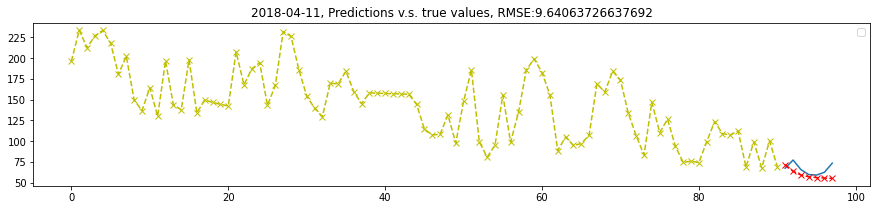

No handles with labels found to put in legend.


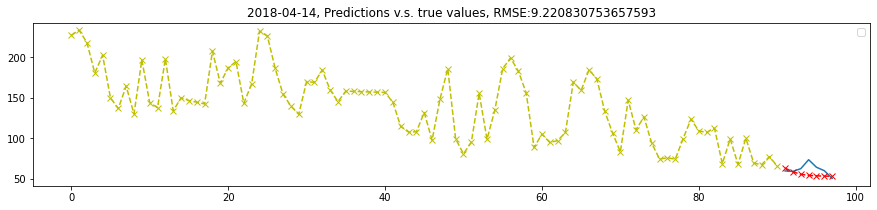

No handles with labels found to put in legend.


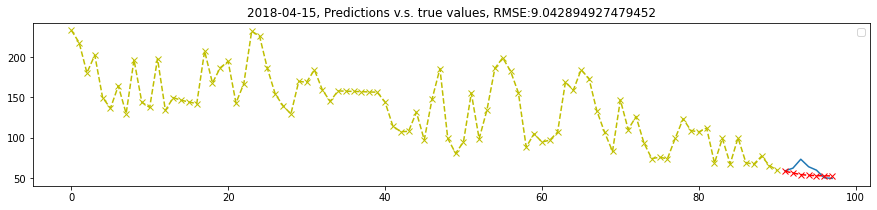

No handles with labels found to put in legend.


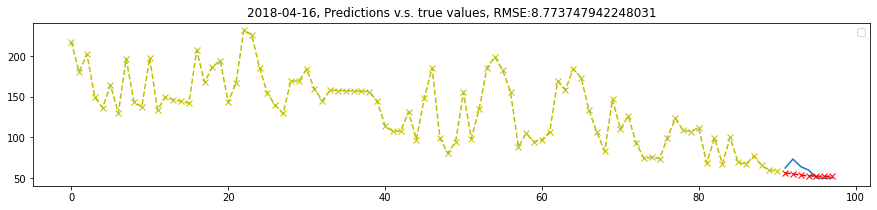

No handles with labels found to put in legend.


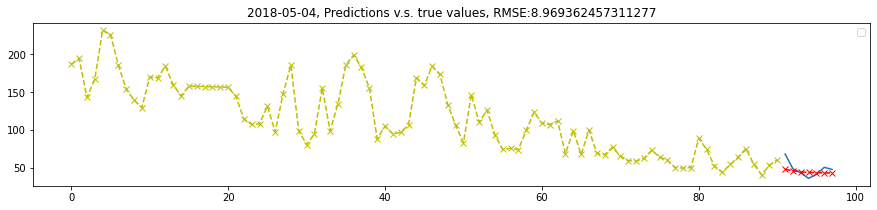

No handles with labels found to put in legend.


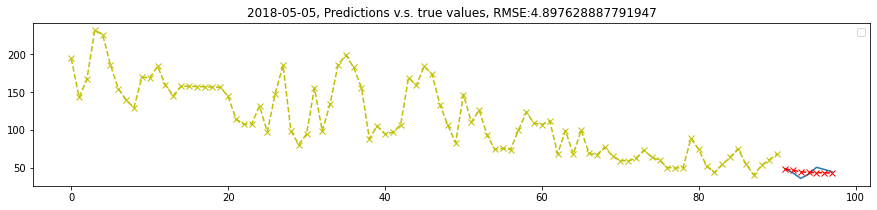

No handles with labels found to put in legend.


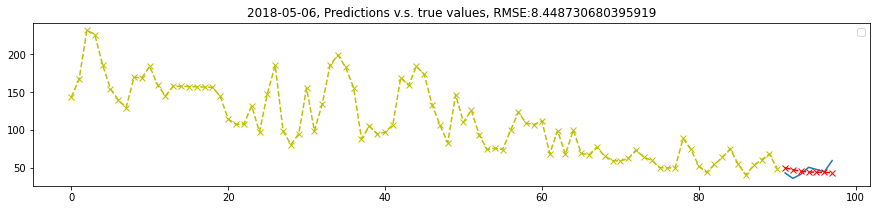

No handles with labels found to put in legend.


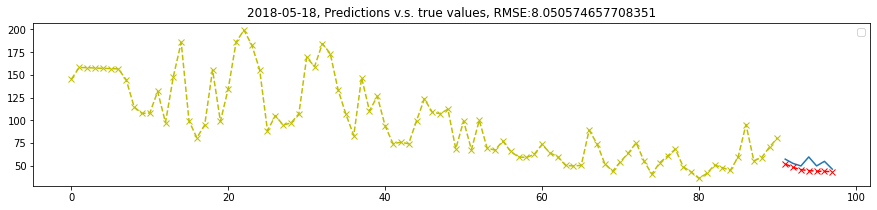

No handles with labels found to put in legend.


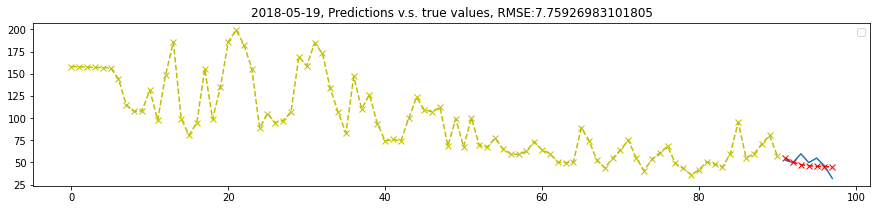

No handles with labels found to put in legend.


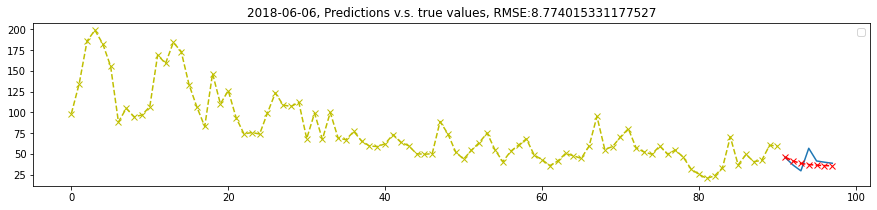

No handles with labels found to put in legend.


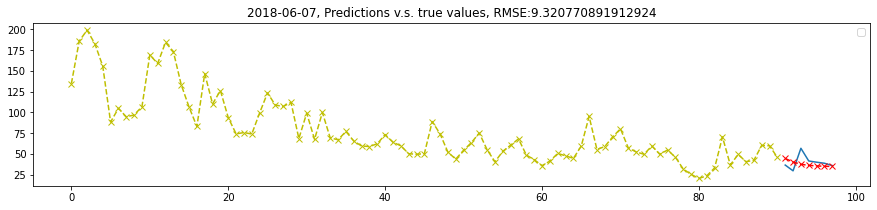

No handles with labels found to put in legend.


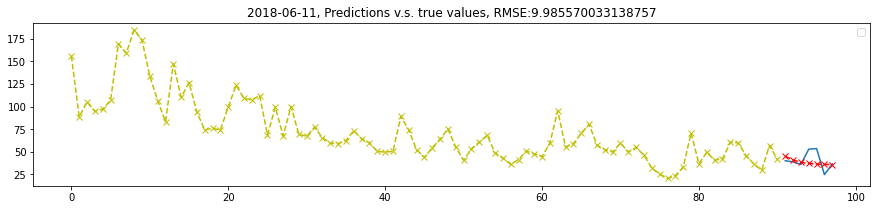

No handles with labels found to put in legend.


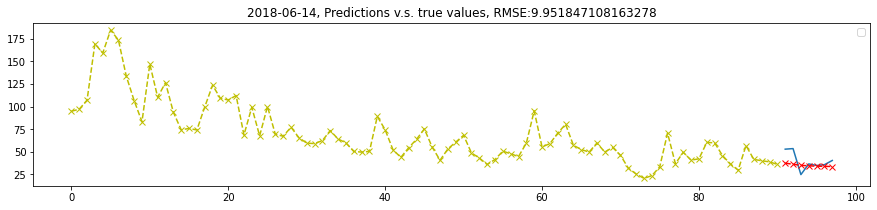

No handles with labels found to put in legend.


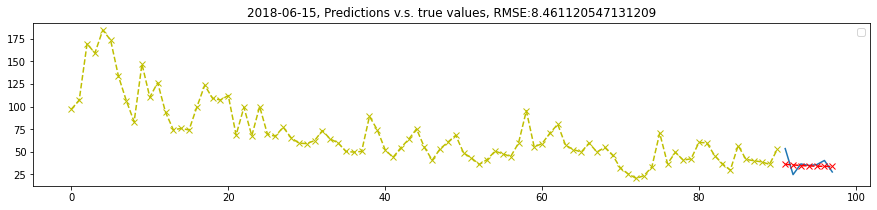

No handles with labels found to put in legend.


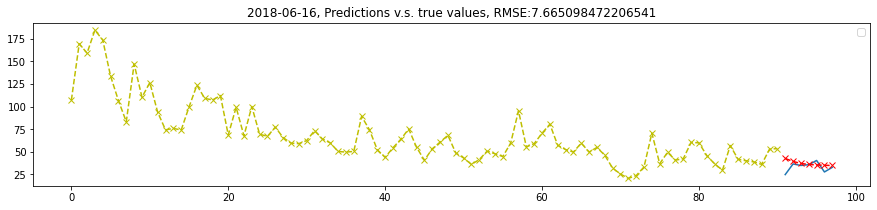

No handles with labels found to put in legend.


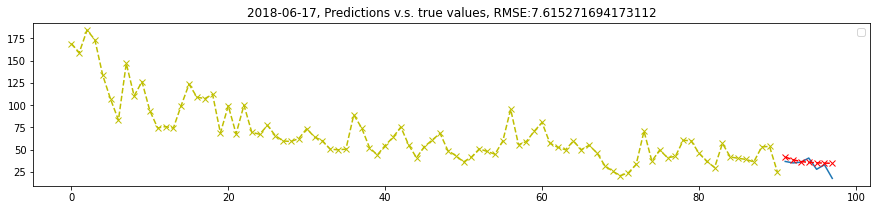

No handles with labels found to put in legend.


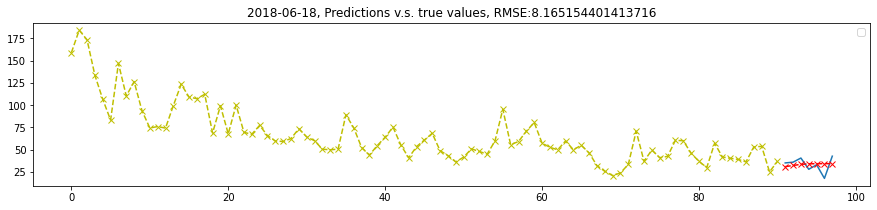

No handles with labels found to put in legend.


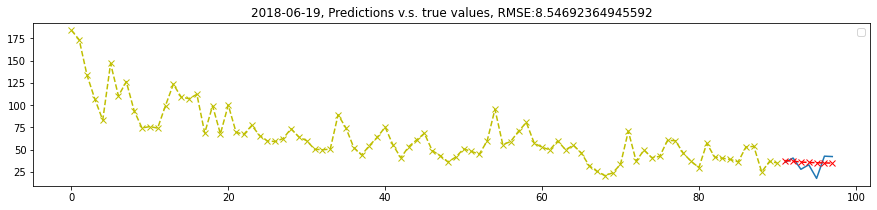

No handles with labels found to put in legend.


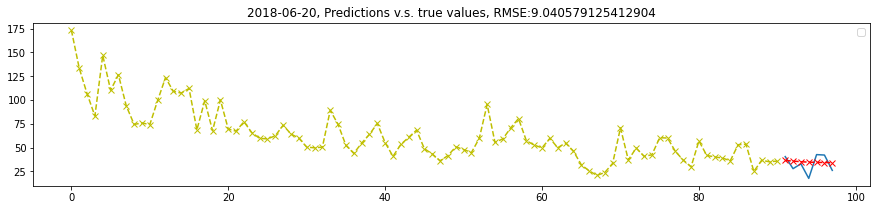

No handles with labels found to put in legend.


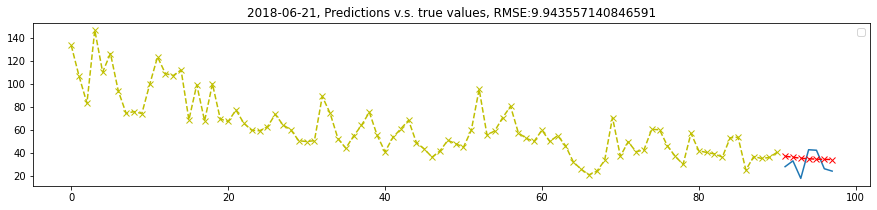

No handles with labels found to put in legend.


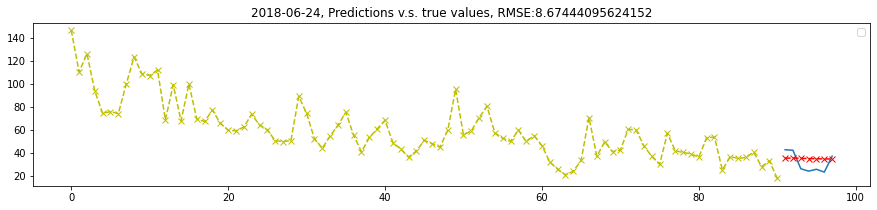

No handles with labels found to put in legend.


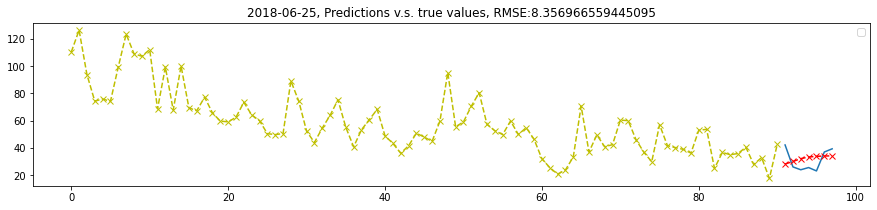

No handles with labels found to put in legend.


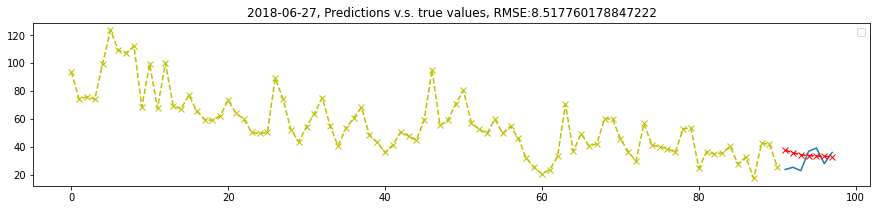

No handles with labels found to put in legend.


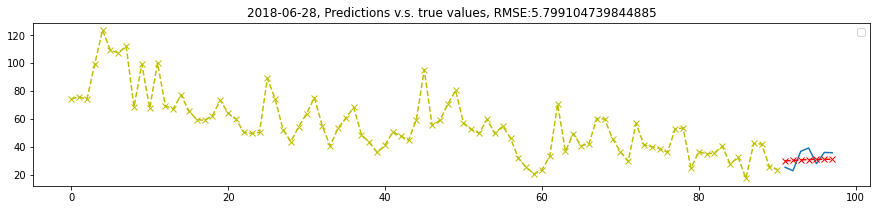

No handles with labels found to put in legend.


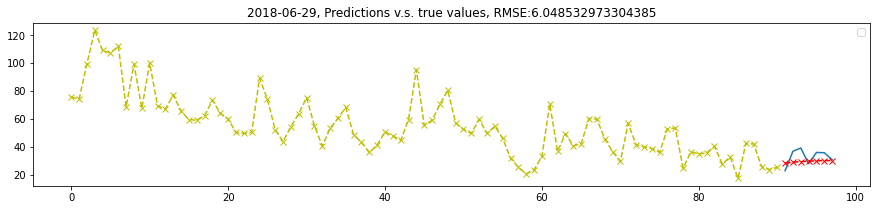

No handles with labels found to put in legend.


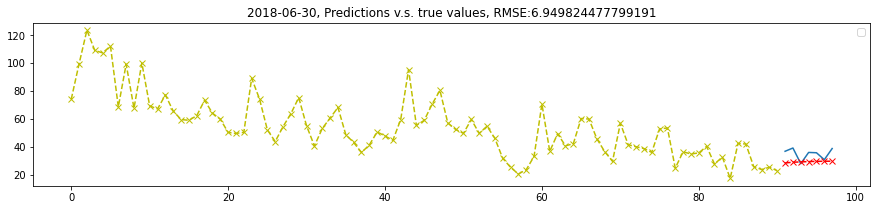

No handles with labels found to put in legend.


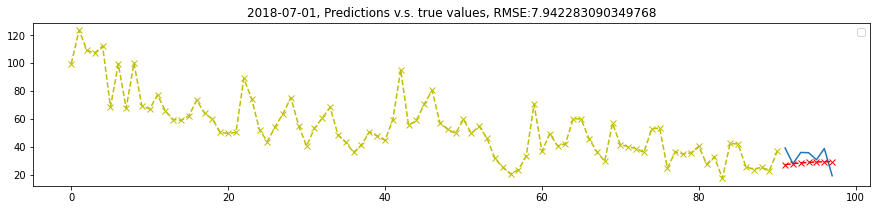

No handles with labels found to put in legend.


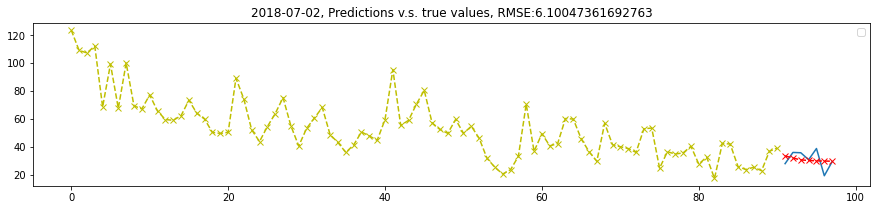

No handles with labels found to put in legend.


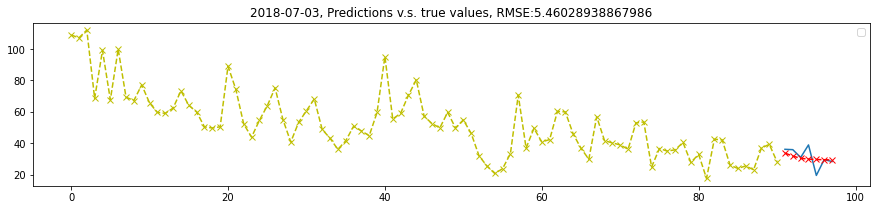

No handles with labels found to put in legend.


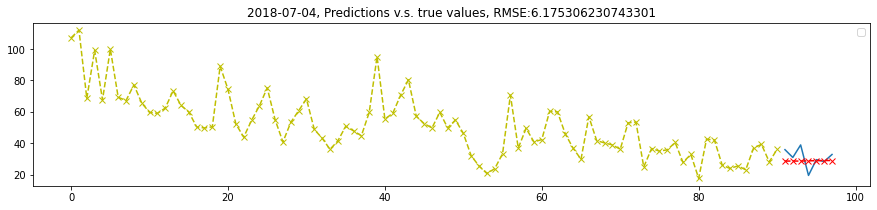

No handles with labels found to put in legend.


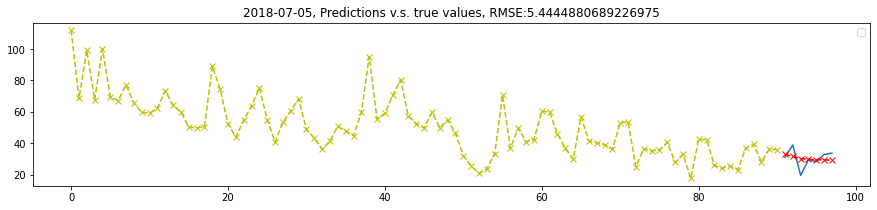

No handles with labels found to put in legend.


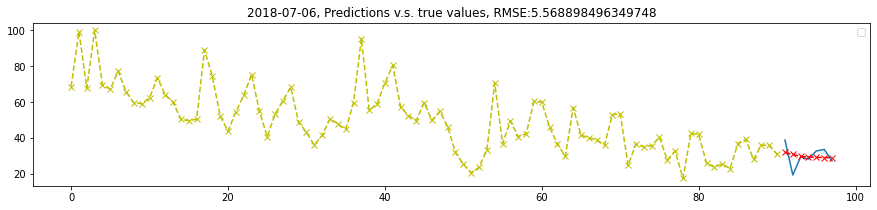

No handles with labels found to put in legend.


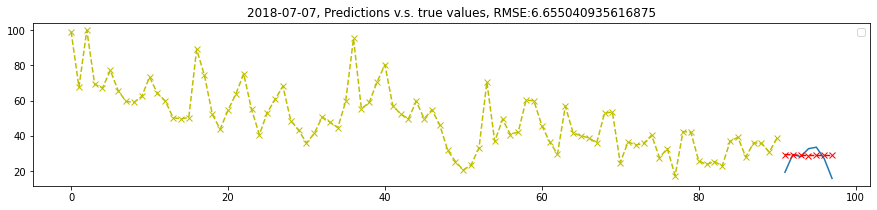

No handles with labels found to put in legend.


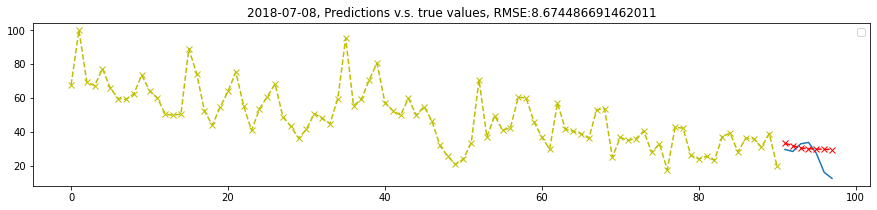

No handles with labels found to put in legend.


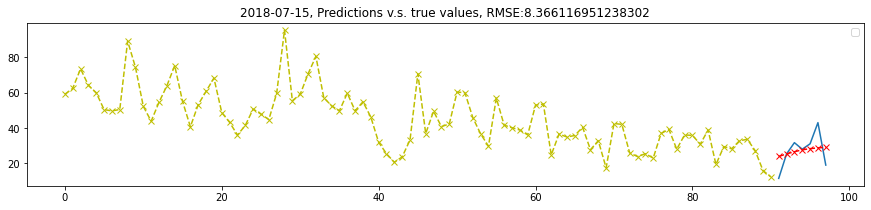

No handles with labels found to put in legend.


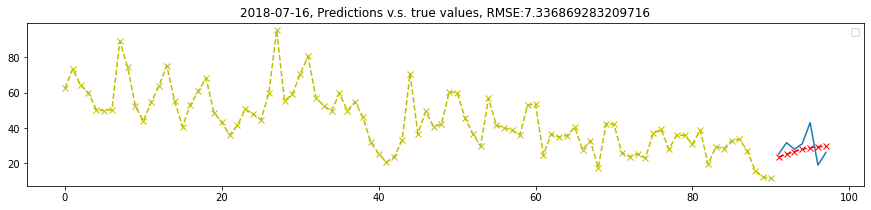

No handles with labels found to put in legend.


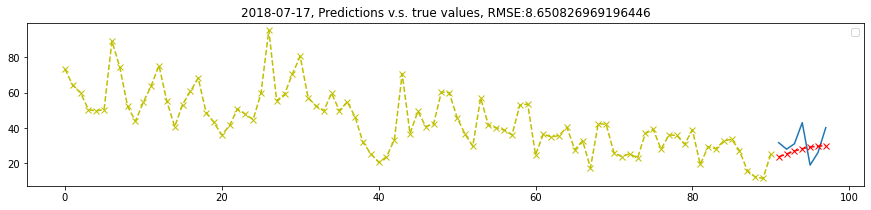

No handles with labels found to put in legend.


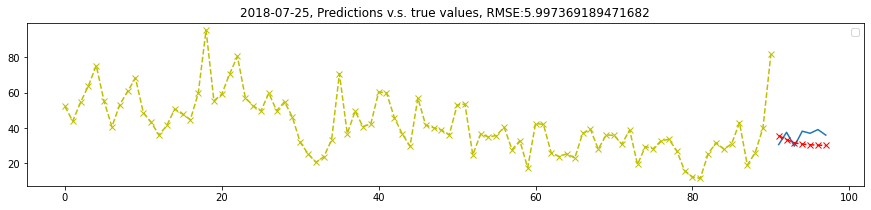

No handles with labels found to put in legend.


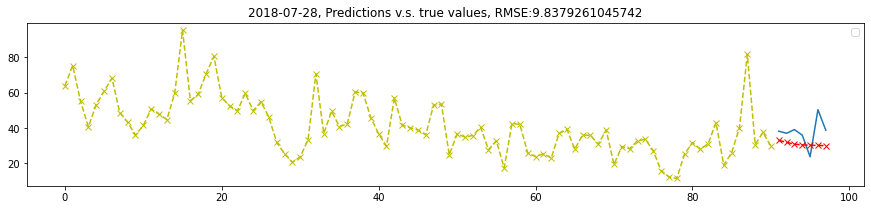

No handles with labels found to put in legend.


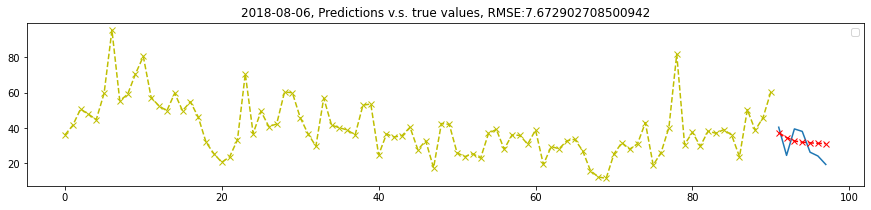

No handles with labels found to put in legend.


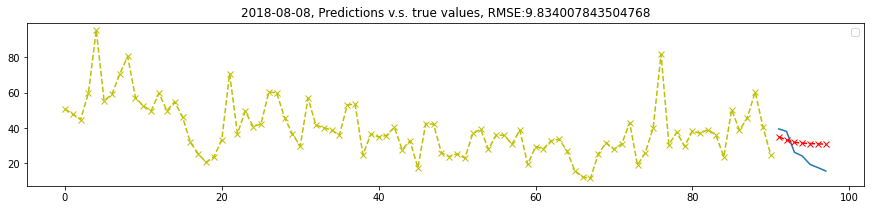

No handles with labels found to put in legend.


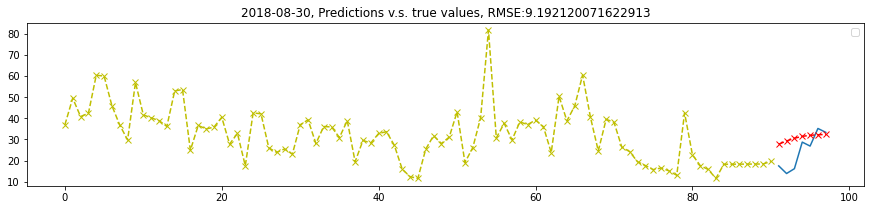

No handles with labels found to put in legend.


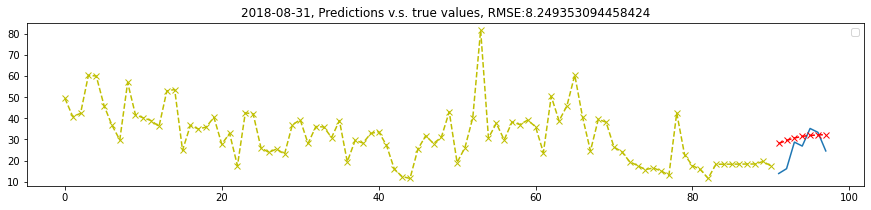

No handles with labels found to put in legend.


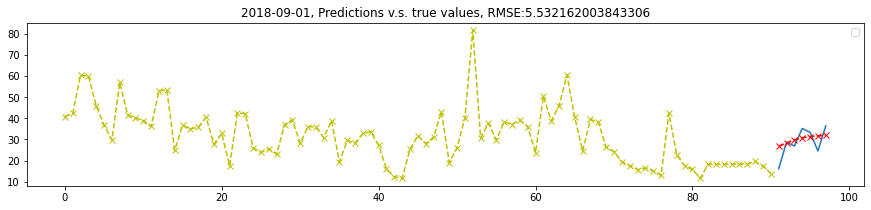

No handles with labels found to put in legend.


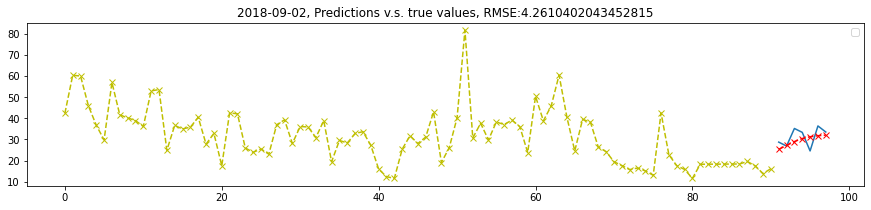

No handles with labels found to put in legend.


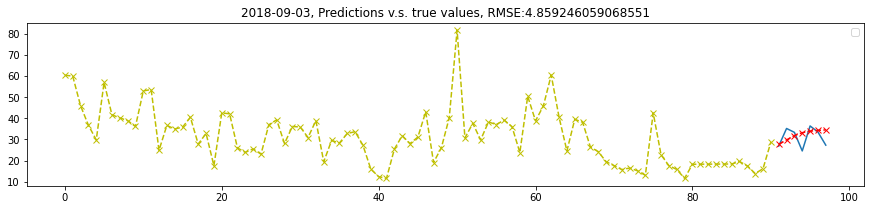

No handles with labels found to put in legend.


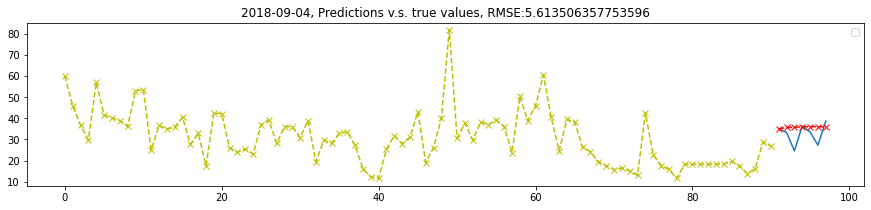

No handles with labels found to put in legend.


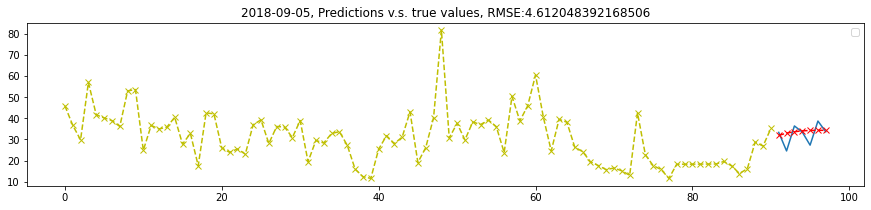

No handles with labels found to put in legend.


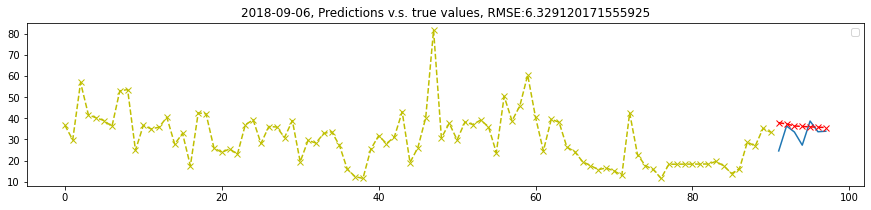

8685.06201767633 359
Average RMSE per sample:  24.192373308290612
Average MAE per sample:  20.872860192588444
lstm_ae: [27.865] 25.9, 27.5, 28.3, 28.4, 28.4, 28.4, 28.0


In [163]:
#On Test with plotting
score,scores = evaluate_model(x_input_train.copy(),label_train.copy(),
                              x_input_test.copy(),label_test.copy(),\
                              prediction_day_test.copy(), n_input, train_model = False,\
                              model = model, test_val = False, normalize =0, plot = 1,\
                              save_path = model_name)
summarize_scores(model_name, score, scores)